Consider using this handy dandy guide: https://bradduthie.shinyapps.io/ecoacoustics/

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import re
import random
from maad import sound, features
from maad.util import (
    date_parser, plot_correlation_map, 
    plot_features_map, plot_features, false_Color_Spectro
    )

Amplitude  
Acoustic (temporal) Entropy (H) - decreases non-linearly with increasing snap rates  
N Peaks (shrimp)  
SPLpp  

In [2]:
# Set Variables
SPECTRAL_FEATURES = ['MEANf', 'VARf', 'SKEWf', 'KURTf', 'NBPEAKS', 'LEQf', 
                     'ENRf', 'BGNf', 'SNRf', 'Hf', 'EAS', 'ECU', 'ECV', 'EPS', 
                     'EPS_KURT', 'EPS_SKEW', 'ACI', 'NDSI', 'rBA', 'AnthroEnergy', 
                     'BioEnergy', 'BI', 'ROU', 'ADI', 'AEI', 'LFC', 'MFC', 'HFC', 
                     'ACTspFract', 'ACTspCount', 'ACTspMean', 'EVNspFract', 
                     'EVNspMean', 'EVNspCount', 'TFSD', 'H_Havrda', 'H_Renyi', 
                     'H_pairedShannon', 'H_gamma', 'H_GiniSimpson', 'RAOQ', 'AGI', 
                     'ROItotal', 'ROIcover']

TEMPORAL_FEATURES = ['ZCR', 'MEANt', 'VARt', 'SKEWt', 'KURTt', 'LEQt', 'BGNt', 
                     'SNRt', 'MED', 'Ht', 'ACTtFraction', 'ACTtCount', 'ACTtMean', 
                     'EVNtFraction', 'EVNtMean', 'EVNtCount']

# Define the list of folders
folders = [
    "/Volumes/SeaBABELa/BVI Mangroves_2024/BVI Mangroves_2024_Working/6863_Paraquita/6863_Paraquita_SoundFiles",
    "/Volumes/SeaBABELa/BVI Mangroves_2024/BVI Mangroves_2024_Working/6879_French/6879_French_SoundFiles",
    "/Volumes/SeaBABELa/BVI Mangroves_2024/BVI Mangroves_2024_Working/6880_HansA/6880_HansA_SoundFiles_Corrected",
    "/Volumes/SeaBABELa/BVI Mangroves_2024/BVI Mangroves_2024_Working/6884_SeaCowBay/6884_SeaCowBay_SoundFiles"
]

# Initialize DataFrames for indices
df_indices = pd.DataFrame()
df_indices_per_bin = pd.DataFrame()

In [18]:
# Iterate over each folder
for folder in folders:
    print(f"Processing folder: {folder}")
    
    # Parse the directory and extract dates and filenames
    df = date_parser(folder, dateformat='%Y%m%d_%H%M%S', verbose=False)

    # Localize the 'date' index to UTC, then convert to AST
    df.index = df.index.tz_localize('UTC').tz_convert('America/Puerto_Rico')
    print(df.columns)

    # Randomly select 100 rows
    if len(df) > 100:
        df_sample = df.sample(n=100)
    else:
        df_sample = df  # if there are less than 100 files, just use all of them.

    for index, row in df_sample.iterrows(): # changed to df_sample
        fullfilename = row['file']
        path, filename = os.path.split(fullfilename)

        print(f"Processing {filename}...")

        try:
            # Load audio file (16-bit audio)
            wave, fs = sound.load(filename=fullfilename, detrend=True, verbose=False)
        except Exception as e:
            print(f"Error loading file {filename}: {e}")
            df.drop(index, inplace=True)
            continue

        # Calculate temporal acoustic indices
        S = -176.3  # Avg. sensitivity for ST400s
        G = 0  # Gain

        df_audio_ind = features.all_temporal_alpha_indices(
            s=wave, fs=fs, gain=G, sensibility=S, 
            dB_threshold=3, rejectDuration=0.01, verbose=False
        )

        # Compute Power Spectrogram Density (PSD)
        Sxx_power, tn, fn, ext = sound.spectrogram(
            x=wave, fs=fs, window='hann', nperseg=1024, noverlap=1024//2, 
            verbose=False, display=False
        )

        # Calculate spectral indices
        df_spec_ind, df_spec_ind_per_bin = features.all_spectral_alpha_indices(
            Sxx_power=Sxx_power, tn=tn, fn=fn, flim_low=[0, 1500], flim_mid=[1500, 8000], 
            flim_hi=[20, 4000], gain=G, sensitivity=S, verbose=False
        )

        # Combine results into a single row
        df_row = pd.DataFrame(row).T
        df_row.index.name = 'Date'
        df_row = df_row.reset_index()

        # Concatenate temporal and spectral indices
        row_scalar_indices = pd.concat([df_row, df_audio_ind, df_spec_ind], axis=1)
        df_indices = pd.concat([df_indices, row_scalar_indices])

        row_vector_indices = pd.concat([df_row, df_spec_ind_per_bin], axis=1)
        df_indices_per_bin = pd.concat([df_indices_per_bin, row_vector_indices])

# Set Date as the index
df_indices = df_indices.set_index('Date')
df_indices_per_bin = df_indices_per_bin.set_index('Date')

Processing folder: /Volumes/SeaBABELa/BVI Mangroves_2024/BVI Mangroves_2024_Working/6863_Paraquita/6863_Paraquita_SoundFiles
Index(['file'], dtype='object')
Processing BVI_mangroves_6863_20240124_111514.wav...
Processing BVI_mangroves_6863_20240212_104514.wav...
Processing BVI_mangroves_6863_20240227_191514.wav...
Processing BVI_mangroves_6863_20240219_041514.wav...
Processing BVI_mangroves_6863_20240216_034514.wav...
Processing BVI_mangroves_6863_20240205_234514.wav...
Processing BVI_mangroves_6863_20240116_011514.wav...
Processing BVI_mangroves_6863_20240207_021514.wav...
Processing BVI_mangroves_6863_20240126_164514.wav...
Processing BVI_mangroves_6863_20240211_014514.wav...
Processing BVI_mangroves_6863_20240115_174358.wav...
Processing BVI_mangroves_6863_20240128_124514.wav...
Processing BVI_mangroves_6863_20240128_024514.wav...
Processing BVI_mangroves_6863_20240218_031514.wav...
Processing BVI_mangroves_6863_20240217_194514.wav...
Processing BVI_mangroves_6863_20240130_044514.wa

In [19]:
# Export the indices DataFrame to a CSV file
df_indices.to_csv('acoustic_indices.csv', index=False)

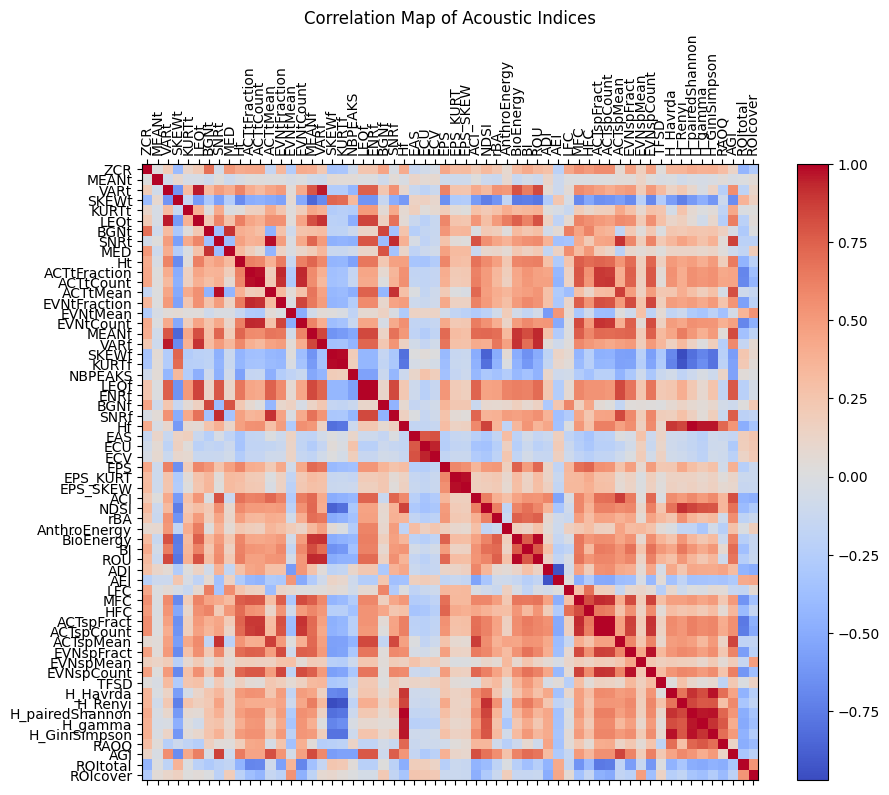

In [20]:
# Display results
import matplotlib.pyplot as plt

# Drop non-numeric columns (such as the file path)
df_indices_numeric = df_indices.select_dtypes(include=['number'])

# Plot a correlation map
fig, ax = plt.subplots(figsize=(10, 8))
df_indices_corr = df_indices_numeric.corr()  # Correlation matrix for numeric columns
cax = ax.matshow(df_indices_corr, cmap='coolwarm')
fig.colorbar(cax)
plt.xticks(range(len(df_indices_corr.columns)), df_indices_corr.columns, rotation=90)
plt.yticks(range(len(df_indices_corr.columns)), df_indices_corr.columns)
plt.title('Correlation Map of Acoustic Indices')
plt.show()

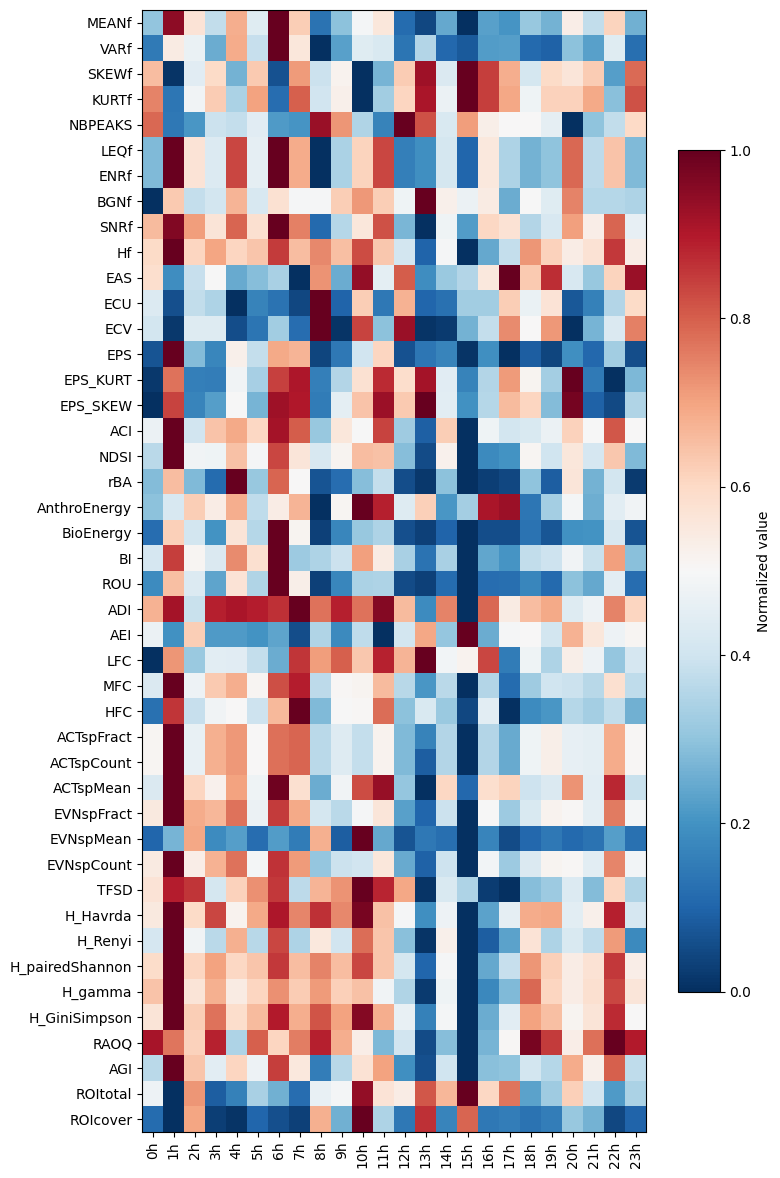

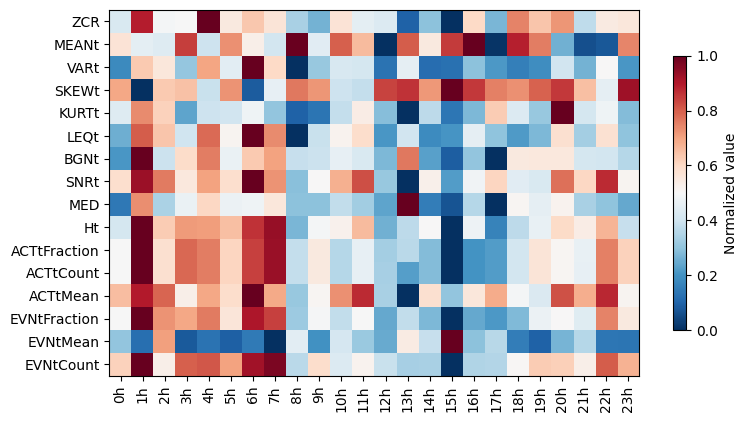

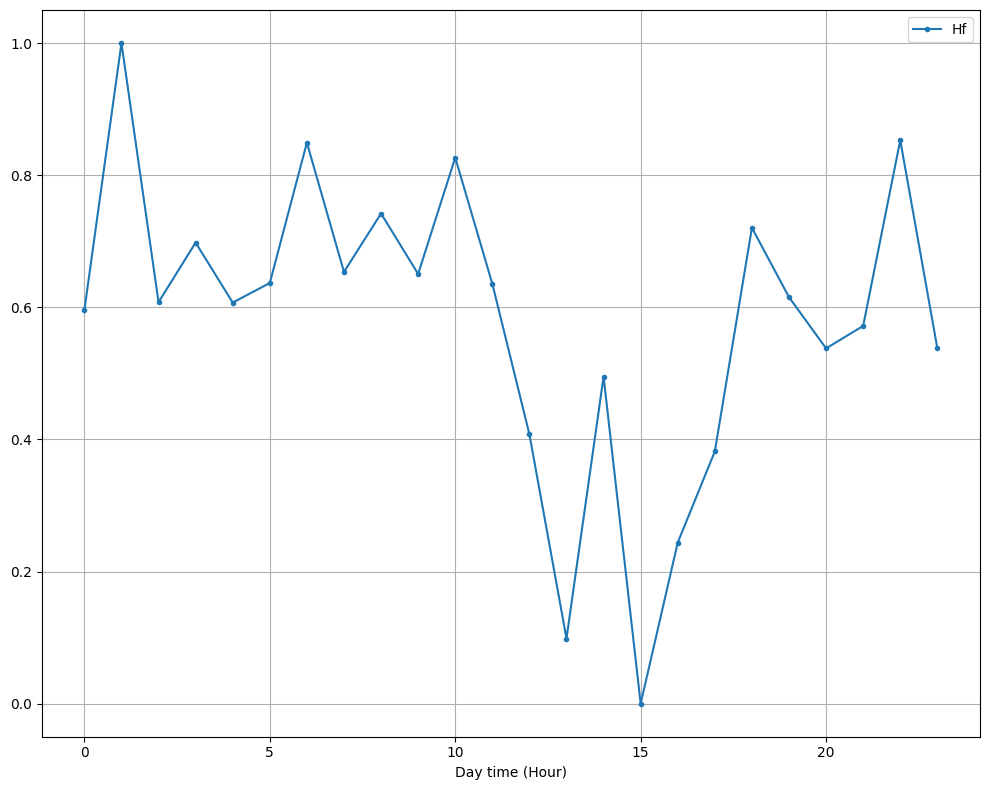

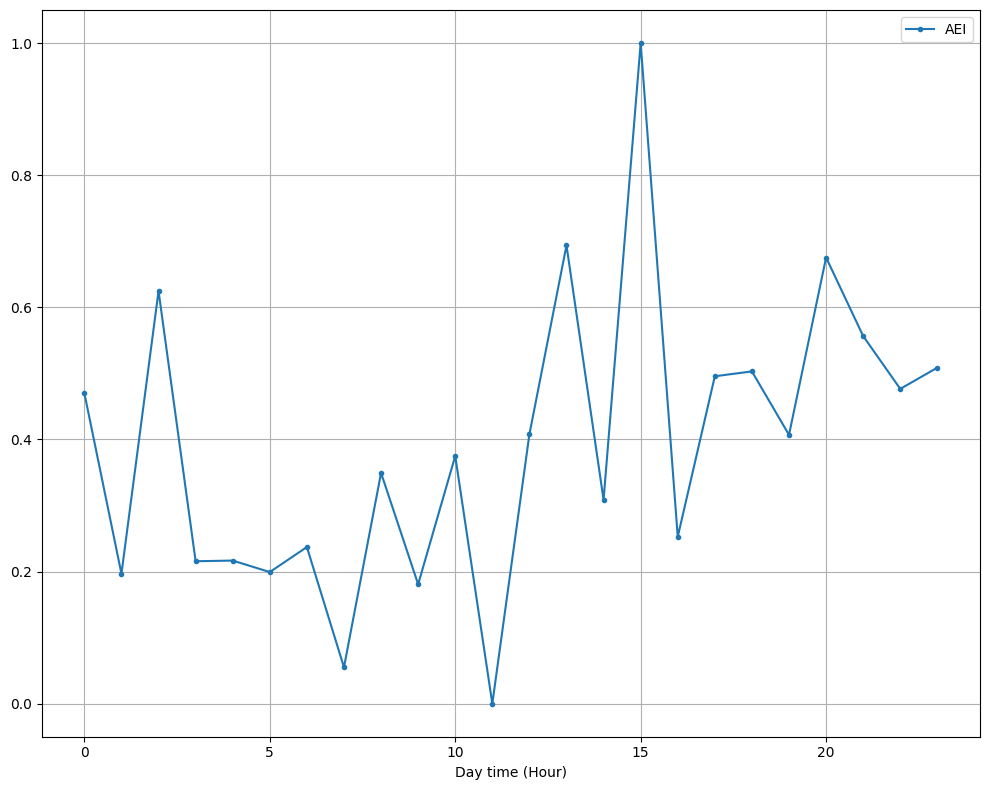

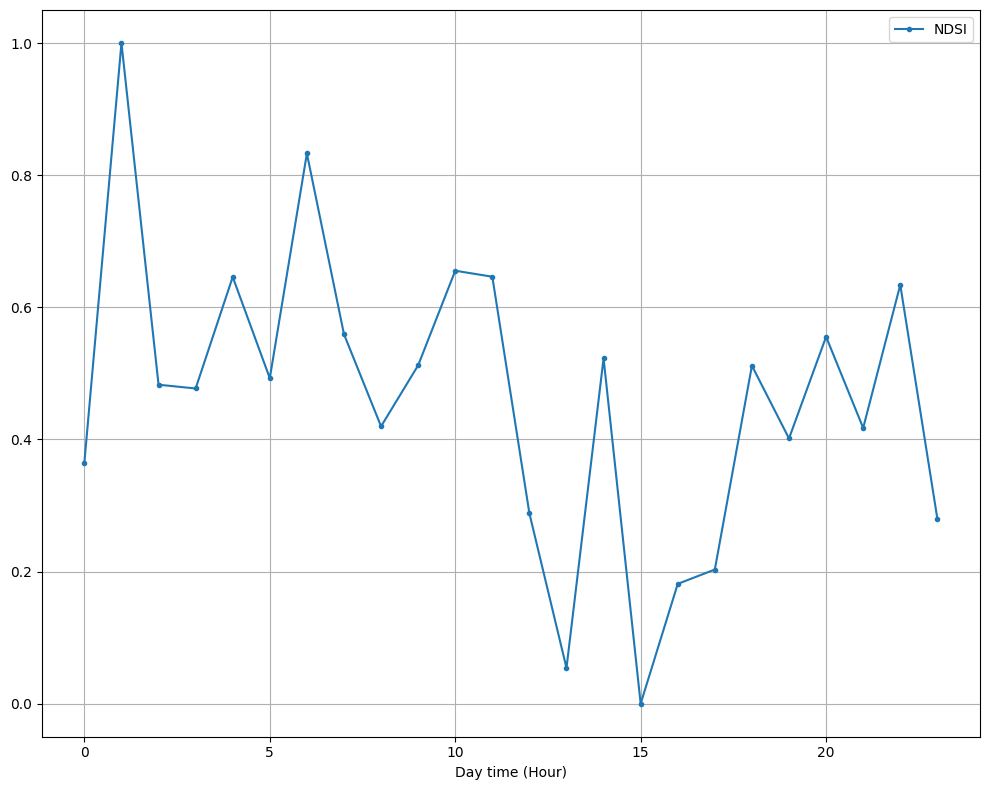

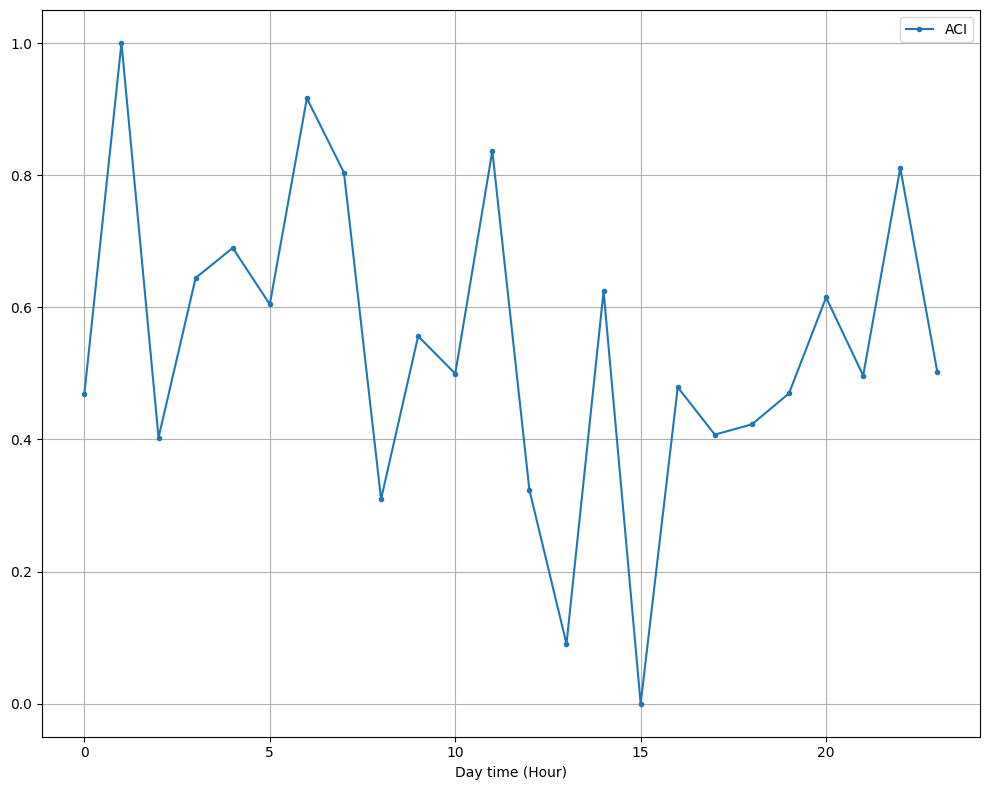

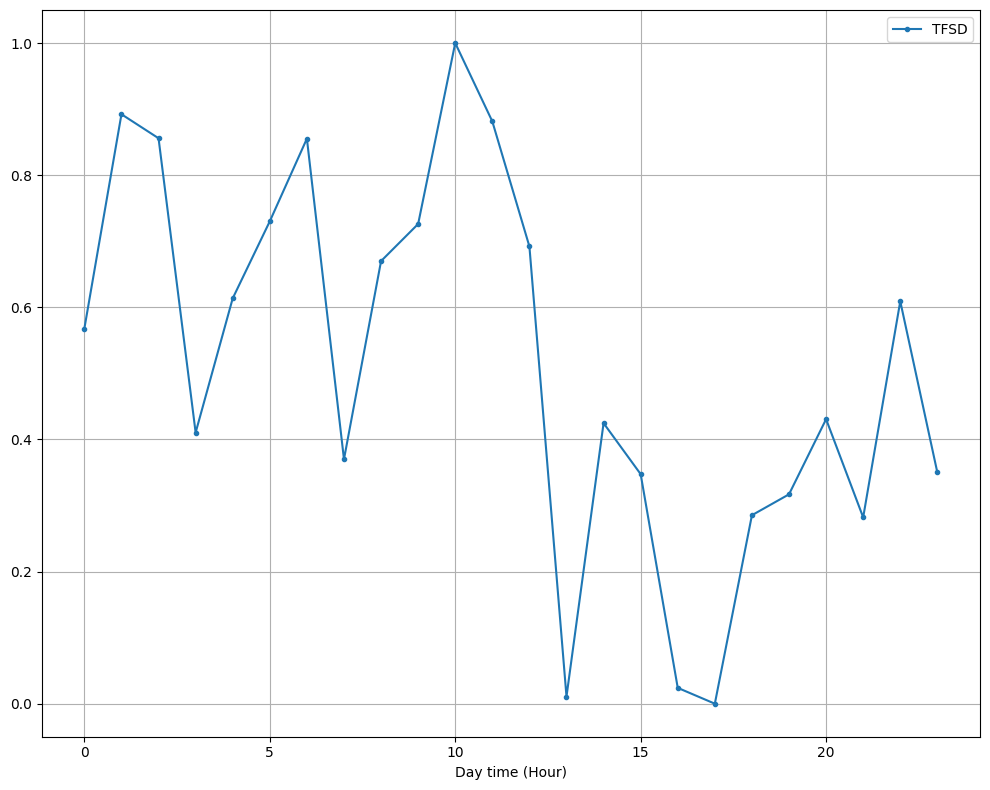

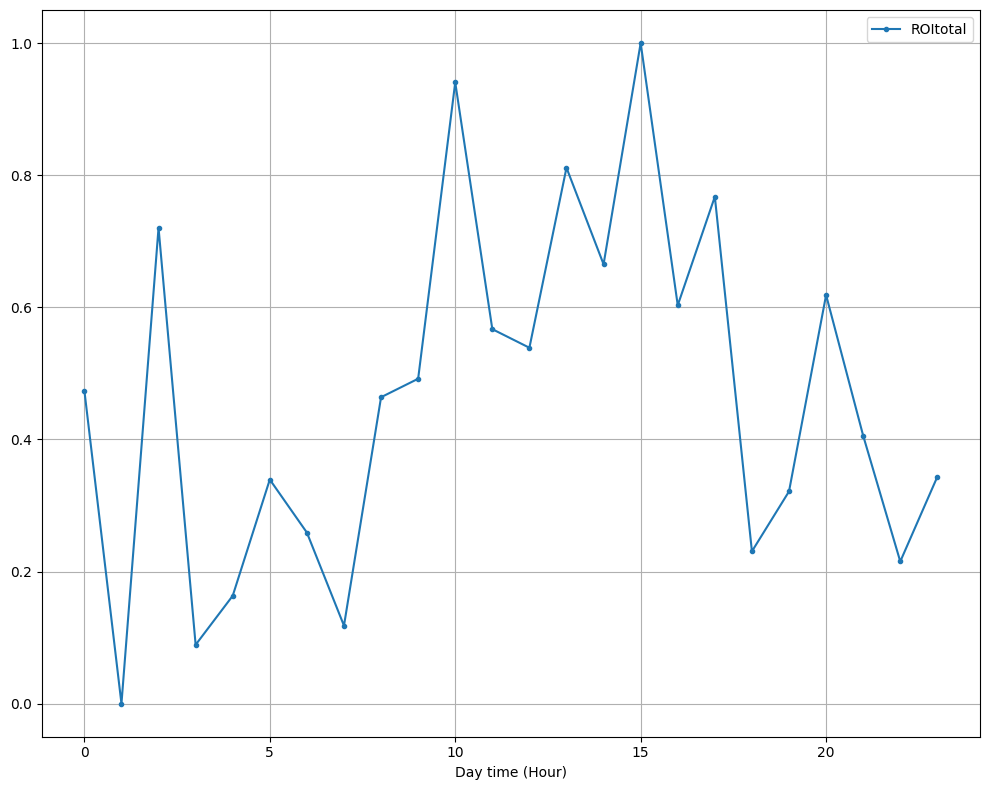

In [21]:
# Plot heatmaps of the indices
from maad.util import plot_features_map
plot_features_map(df_indices_numeric[SPECTRAL_FEATURES], mode='24h')
plot_features_map(df_indices_numeric[TEMPORAL_FEATURES], mode='24h')

# A more classical way to analyse variations of indices consists in plotting
# graphs. We choose to normalize rescale their value between 0 to 1 in order to
# compare their trend during a 24h cycle

# Plot each index individually
fig, ax = plt.subplots(figsize=(10, 8))
plot_features(df_indices[['Hf']], norm=True, mode='24h', ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(10, 8))
plot_features(df_indices[['AEI']], norm=True, mode='24h', ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(10, 8))
plot_features(df_indices[['NDSI']], norm=True, mode='24h', ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(10, 8))
plot_features(df_indices[['ACI']], norm=True, mode='24h', ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(10, 8))
plot_features(df_indices[['TFSD']], norm=True, mode='24h', ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(10, 8))
plot_features(df_indices[['ROItotal']], norm=True, mode='24h', ax=ax)
plt.show()


In [22]:
import pandas as pd
import re
import matplotlib.pyplot as plt

# Filepath to your CSV
csv_filepath = "/Users/jillmunger/Desktop/UNH/coding/bvi_mangroves/acoustic_indices/acoustic_indices.csv"

# Read the CSV into a DataFrame
try:
    df_indices = pd.read_csv(csv_filepath)
except FileNotFoundError:
    print(f"Error: File not found at {csv_filepath}")
    exit()  # Stop execution if the file is not found

# Check if 'file' column exists
if 'file' not in df_indices.columns:
    print("Error: 'file' column not found in the CSV.")
    print("Columns in the CSV:", df_indices.columns)
    exit()

# Function to extract the site number from the filename
def extract_site_number(file):
    """Extracts the 4-digit site number from the filename."""
    filename = file.split('/')[-1]  # Get the filename after the last /
    match = re.search(r'BVI_mangroves_(\d{4})_', filename)  # Look for BVI_mangroves_4digits_
    if match:
        return int(match.group(1))
    else:
        return None

def extract_date(file):
    """Extracts the date (YYYYMMDD) from the filename."""
    match = re.search(r'_(\d{8})_', file)
    if match:
        date_str = match.group(1)
        return pd.to_datetime(date_str, format='%Y%m%d')
    else:
        return None

def extract_time_str(file):
    """Extracts the time (HHMMSS) as a string from the filename."""
    match = re.search(r'_(\d{6})\.wav$', file)  # Look for _HHMMSS.wav at the end
    if match:
        return match.group(1)  # Return the time string (HHMMSS)
    else:
        return None

def extract_hour_from_time_string(time_str):
    """Extracts the hour from a HHMMSS time string."""
    if time_str:
        return int(time_str[:2])  # Extract the first two characters (hour)
    else:
        return None

# Dictionary mapping site numbers to site names
site_mapping = {
    6863: 'paraquita',
    6879: 'french',
    6880: 'hans',
    6864: 'scb'
}

# Apply extraction to df_indices
df_indices['Site'] = df_indices['file'].apply(lambda x: site_mapping.get(extract_site_number(x), 'Unknown'))
df_indices['Date'] = df_indices['file'].apply(extract_date)
df_indices['Time'] = df_indices['file'].apply(extract_time_str)
df_indices['Hour'] = df_indices['Time'].apply(extract_hour_from_time_string)

# Group by hour and calculate the mean of 'Hf' for each hour
hourly_means = df_indices.groupby('Hour')['Hf'].mean()

# Now you can filter the dataframe by site
for site_num, site_name in site_mapping.items():
    site_data = df_indices[df_indices['Site'] == site_name]
    print(f"Data for {site_name}:")
    print(site_data.head())

# Get the list of index columns (starting from the second column)
index_columns = df_indices.columns[1:].tolist()

Data for paraquita:
                                                file          ZCR  \
0  /Volumes/SeaBABELa/BVI Mangroves_2024/BVI Mang...  5409.807428   
1  /Volumes/SeaBABELa/BVI Mangroves_2024/BVI Mang...  3287.228189   
2  /Volumes/SeaBABELa/BVI Mangroves_2024/BVI Mang...  2933.910939   
3  /Volumes/SeaBABELa/BVI Mangroves_2024/BVI Mang...  4416.557559   
4  /Volumes/SeaBABELa/BVI Mangroves_2024/BVI Mang...  2296.203933   

          MEANt      VARt      SKEWt        KURTt       LEQt       BGNt  \
0 -5.333310e-18  0.000010  32.680207  1271.425597  84.916980 -63.756806   
1 -4.157966e-18  0.000010  31.701184  1521.815420  85.003714 -67.859236   
2 -3.816665e-19  0.000015  34.284017  1995.190123  86.717684 -68.549419   
3 -3.291109e-18  0.000010  32.440913  1252.158333  84.838746 -67.015338   
4 -2.795488e-18  0.000010  32.279522  1238.751103  84.850093 -69.702418   

        SNRt       MED  ...       H_gamma  H_GiniSimpson      RAOQ       AGI  \
0  17.062359  0.000649  ...  55433

Pay attention to:
ACI - non-linear increase with snap rates  
Bioacoustics Index    
Amplitude  
Acoustic (temporal) Entropy (H) - decreases non-linearly with increasing snap rates  
N Peaks (shrimp)  
SPLpp  

Raick, X., Gervaise, C., Lecchini, D., and Parmentier, É. (2025). “Limitations of α-acoustic diversity indices in assessing invertebrate sounds in coral reefs,” Bioacoustics, , doi: 10.1080/09524622.2025.2474482. doi:10.1080/09524622.2025.2474482

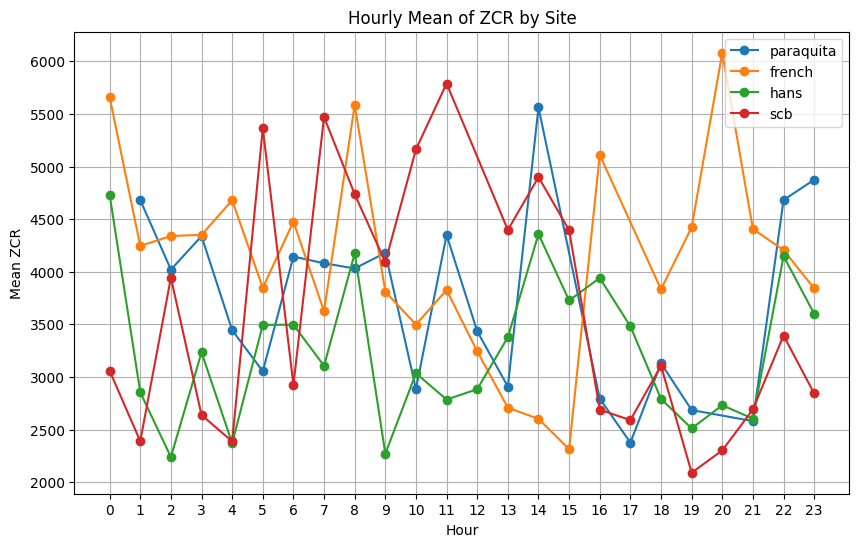

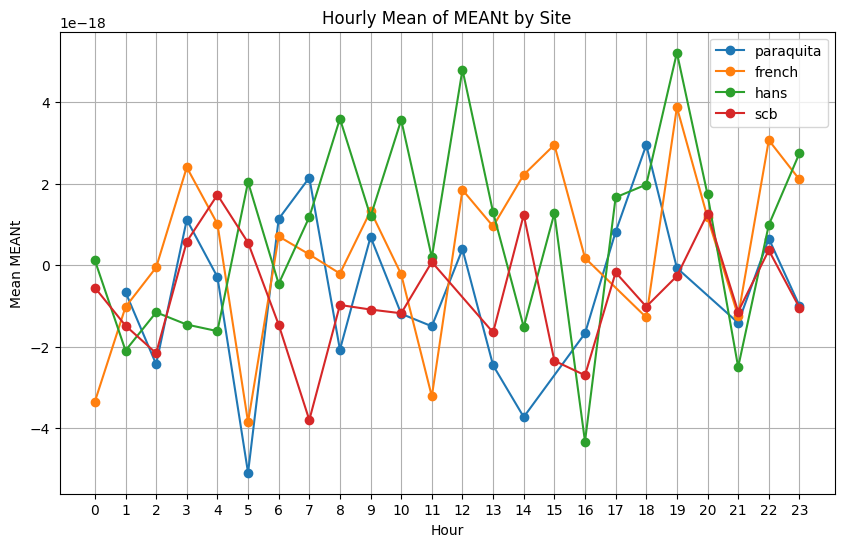

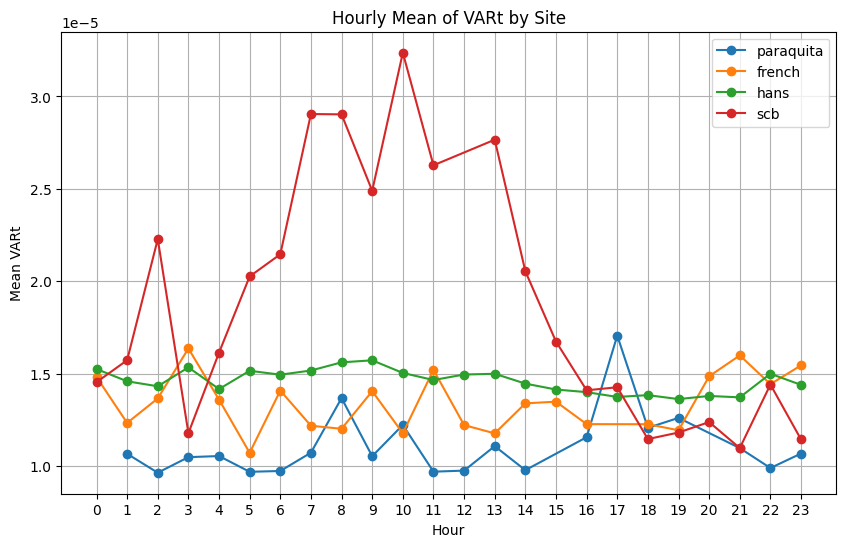

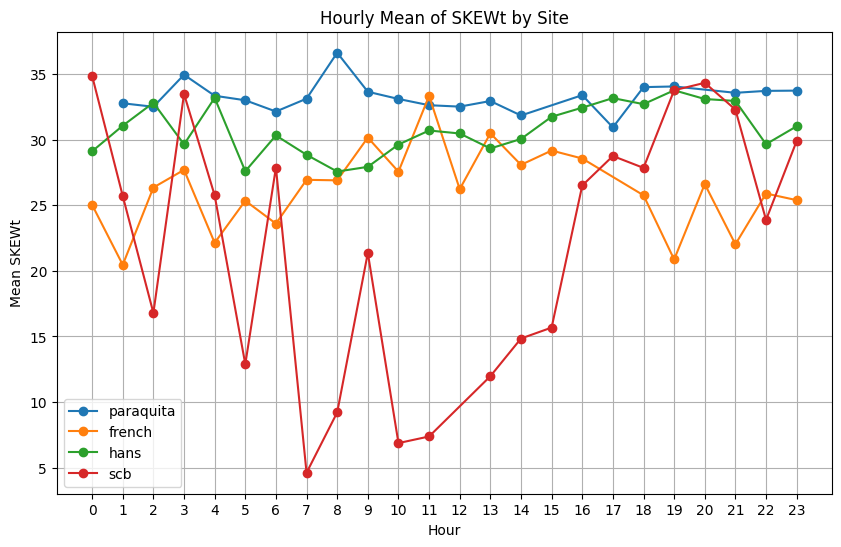

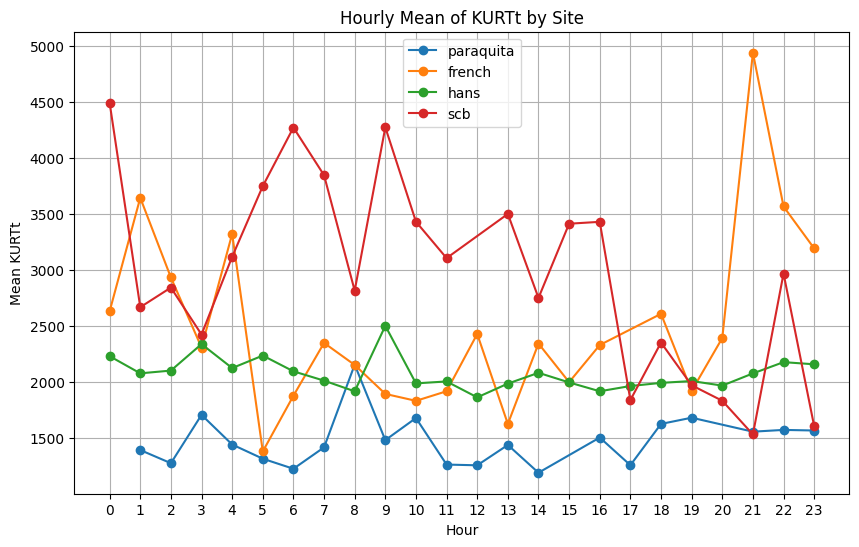

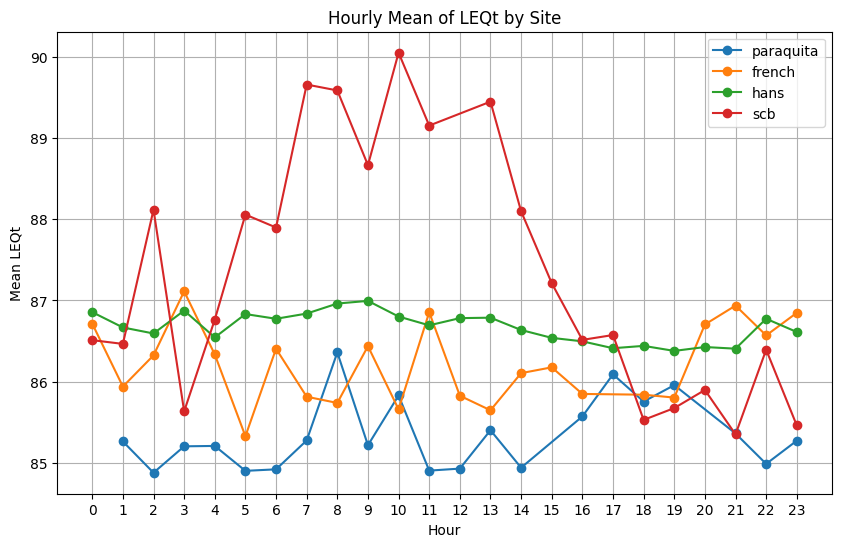

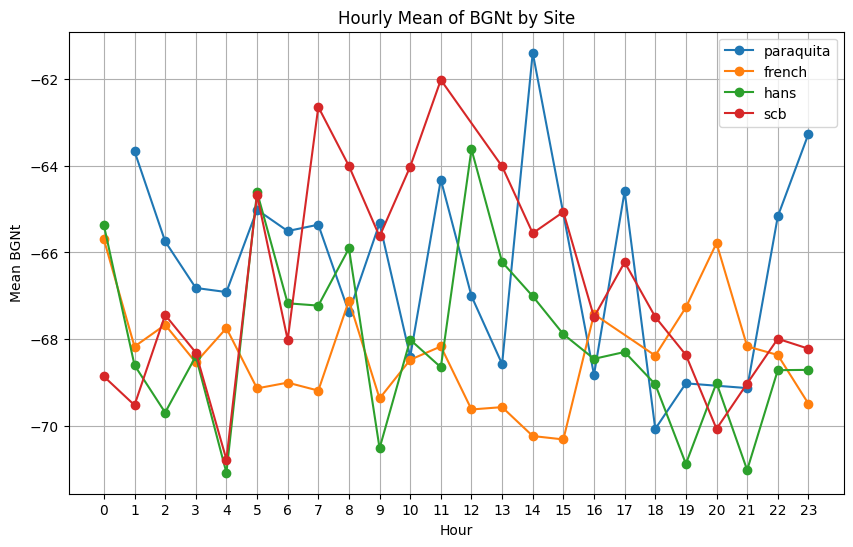

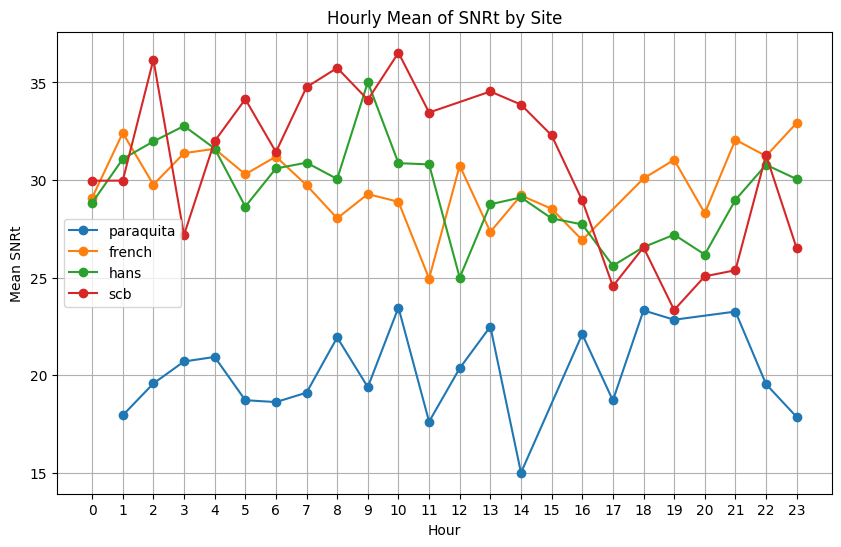

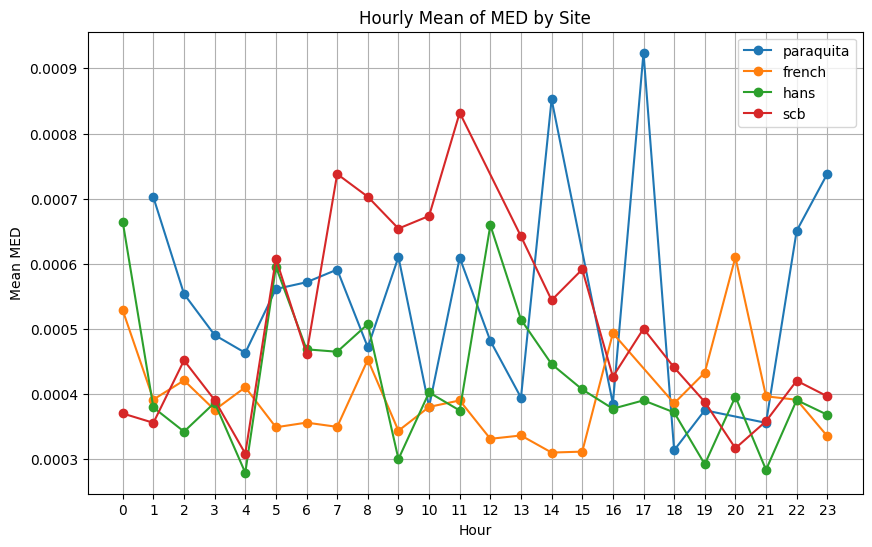

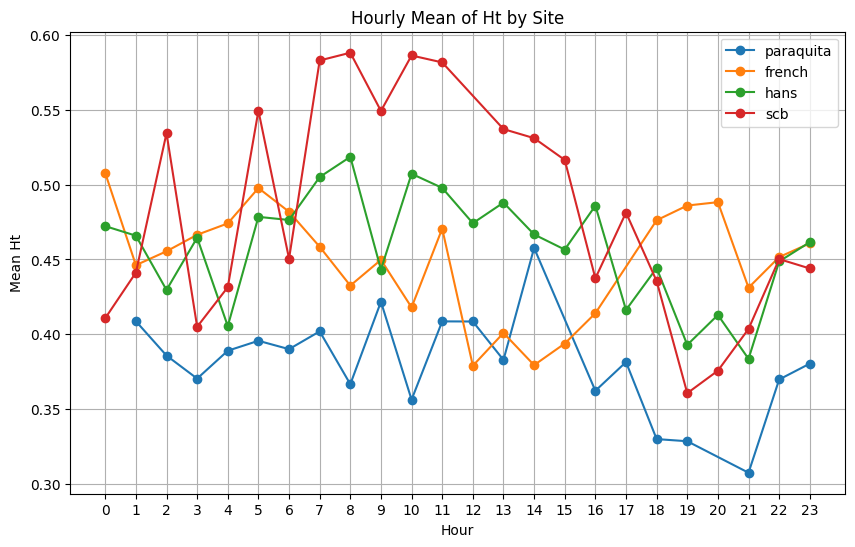

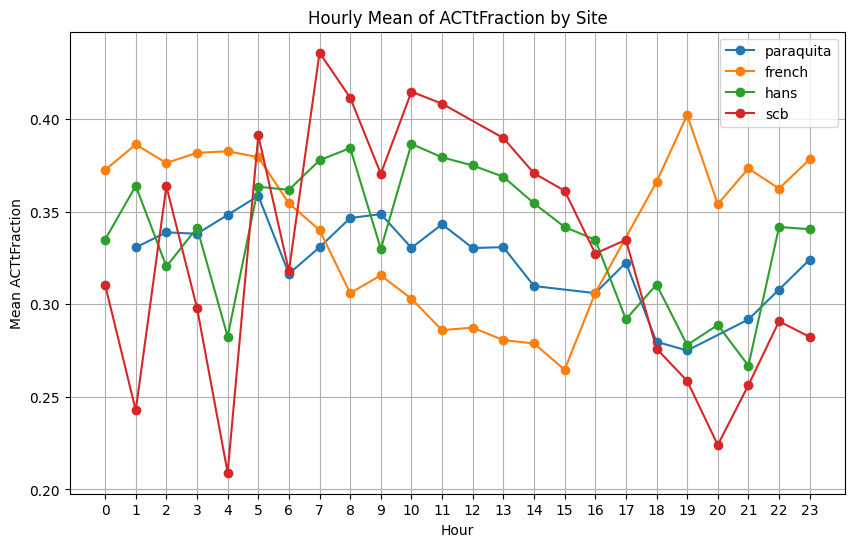

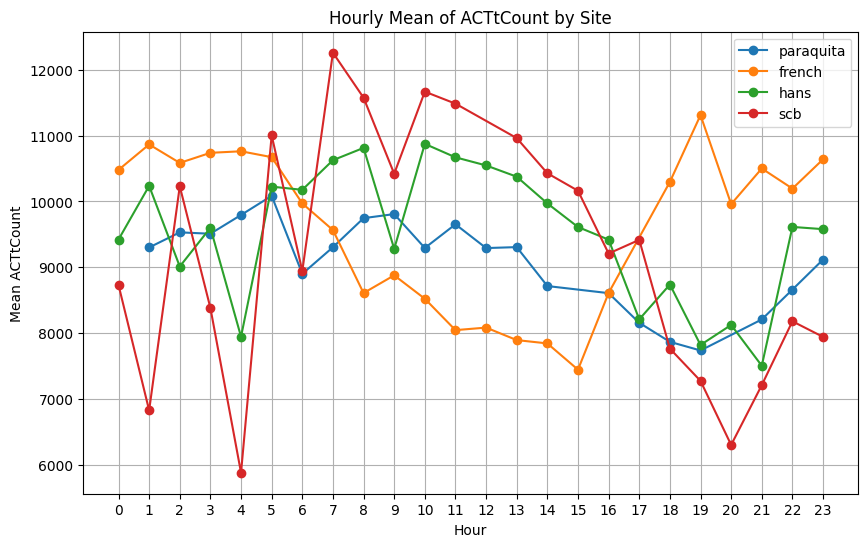

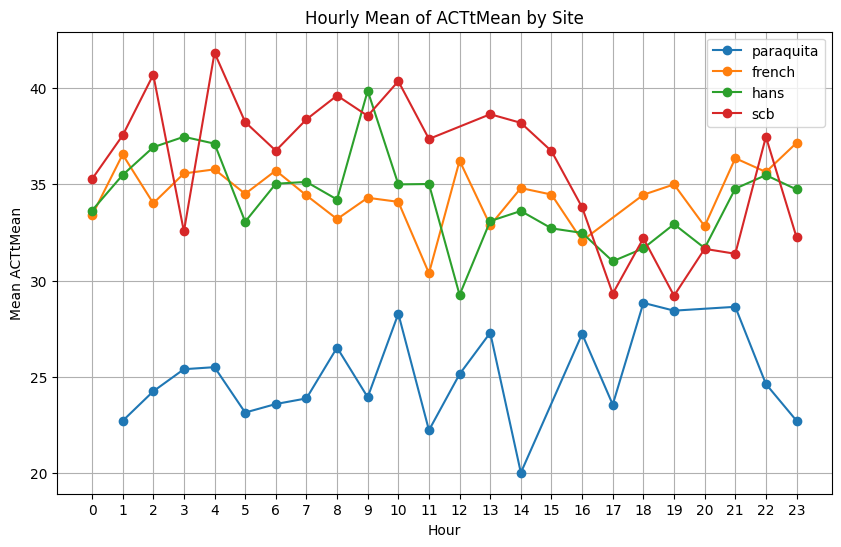

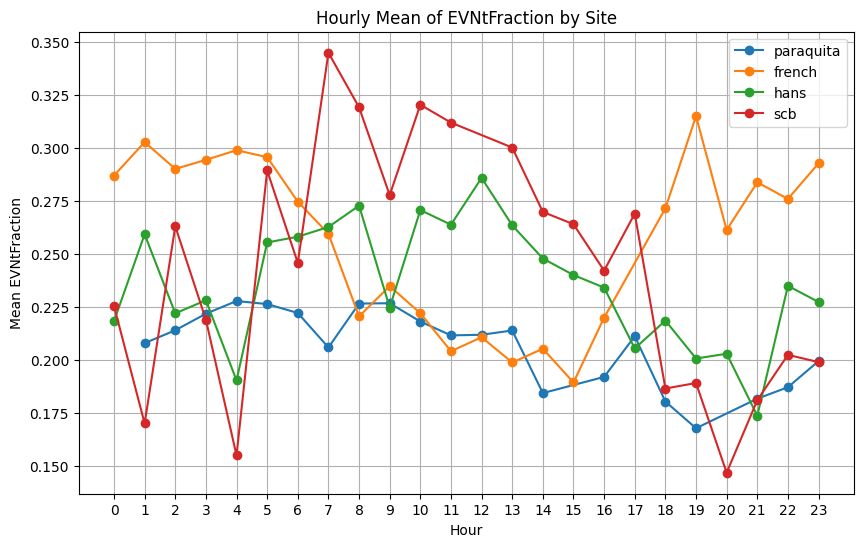

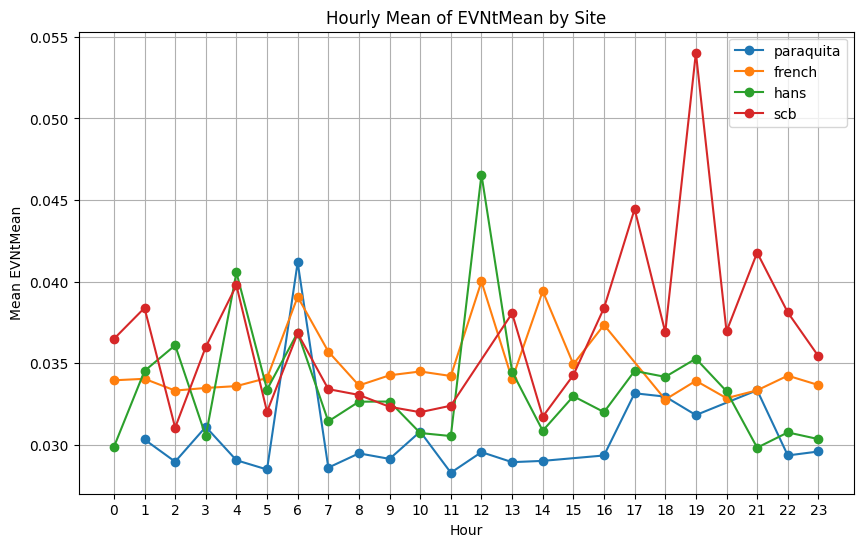

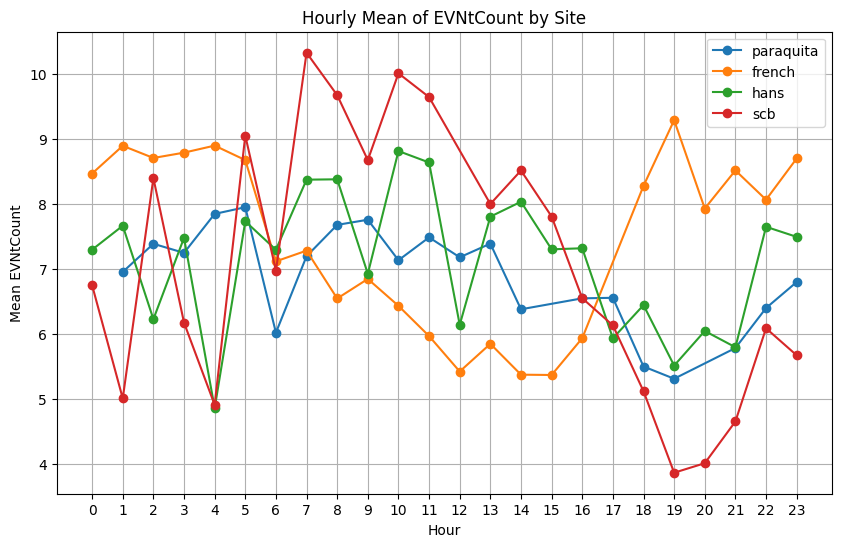

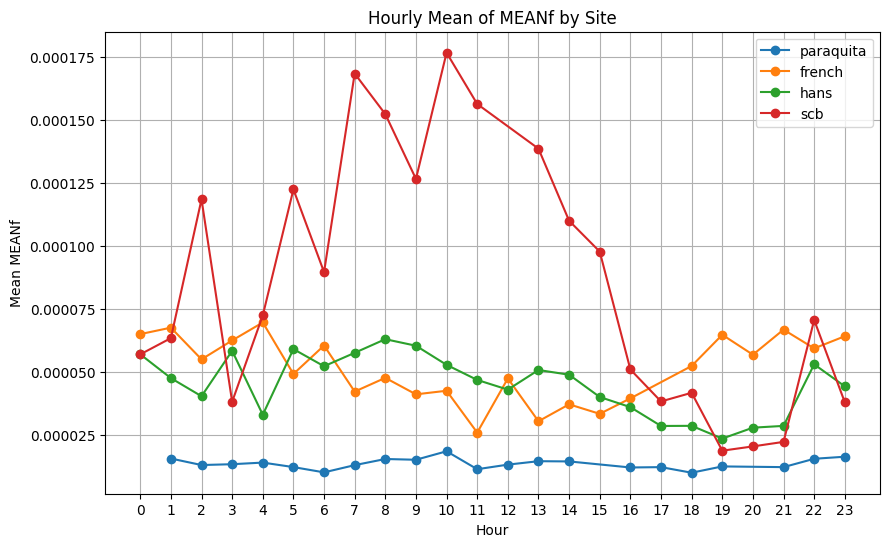

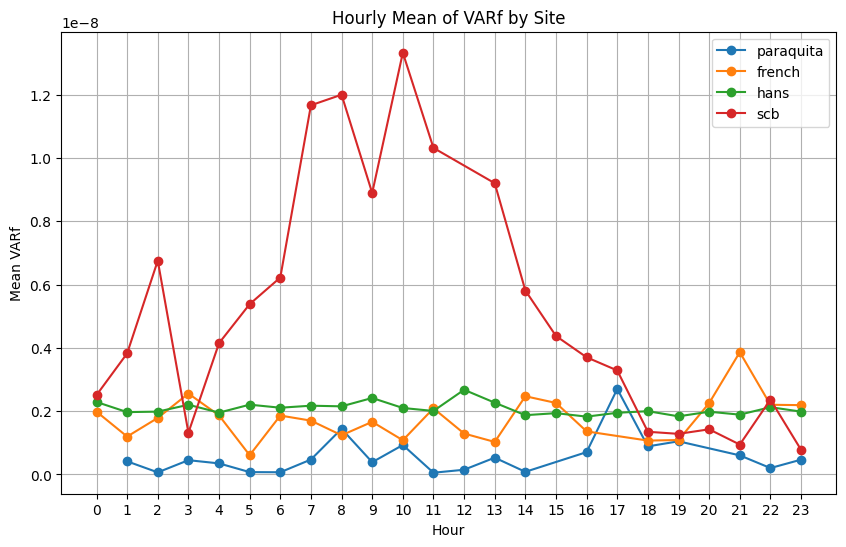

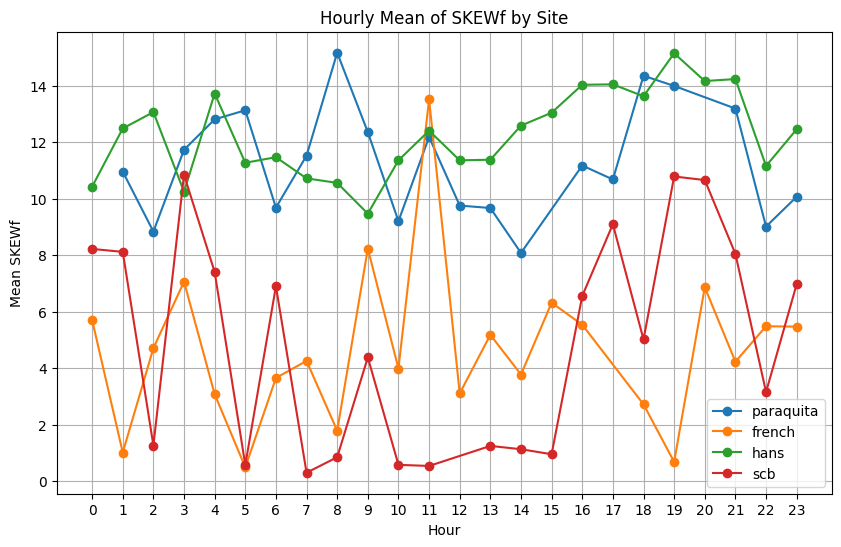

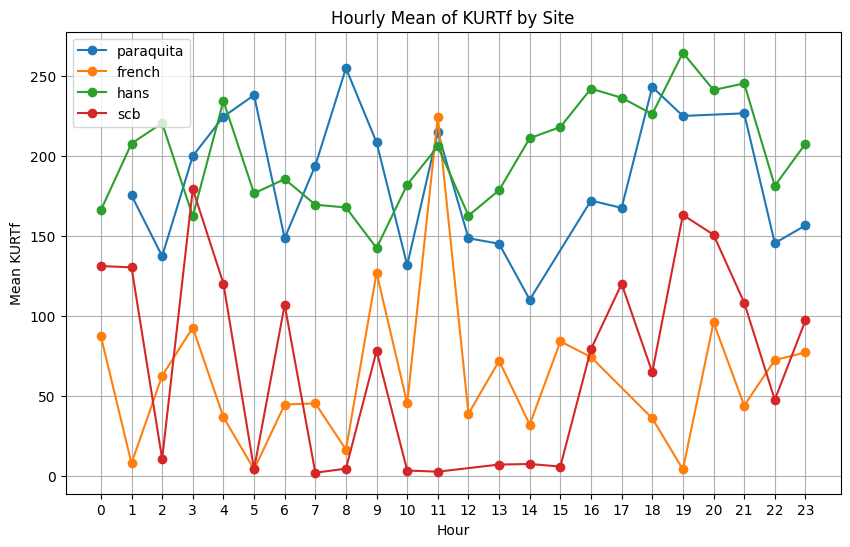

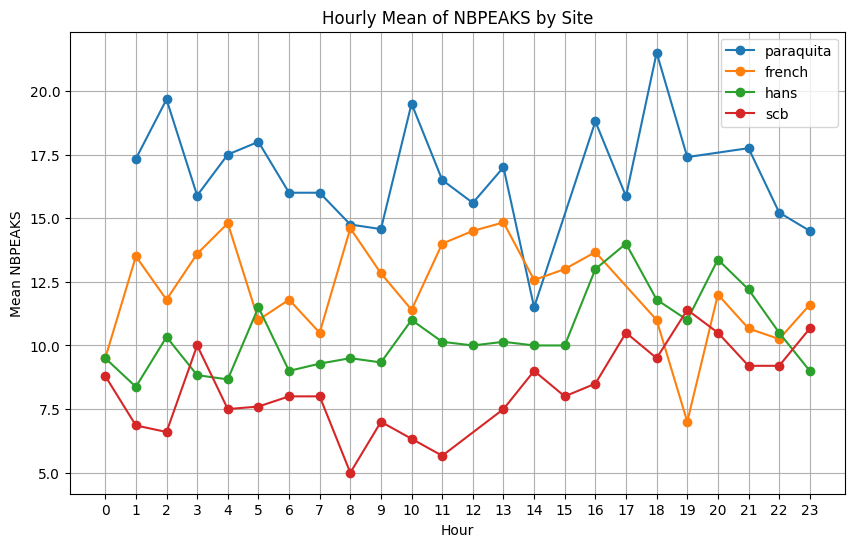

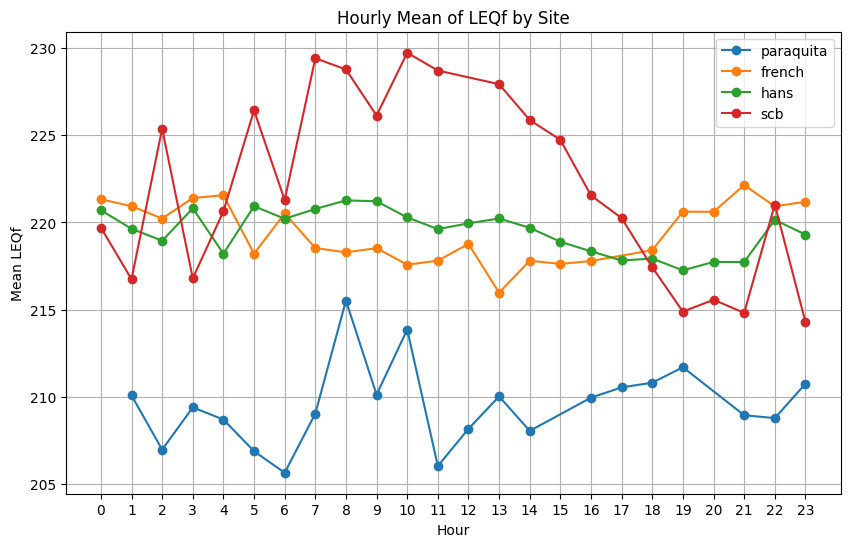

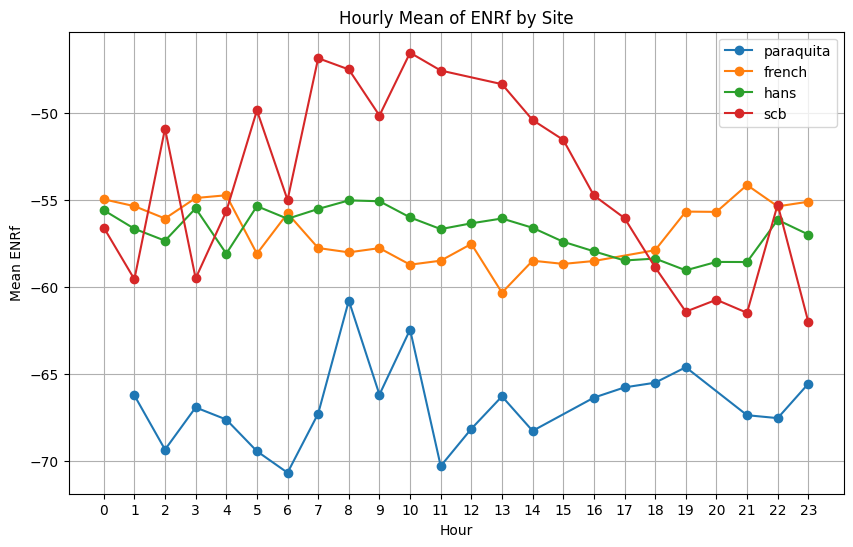

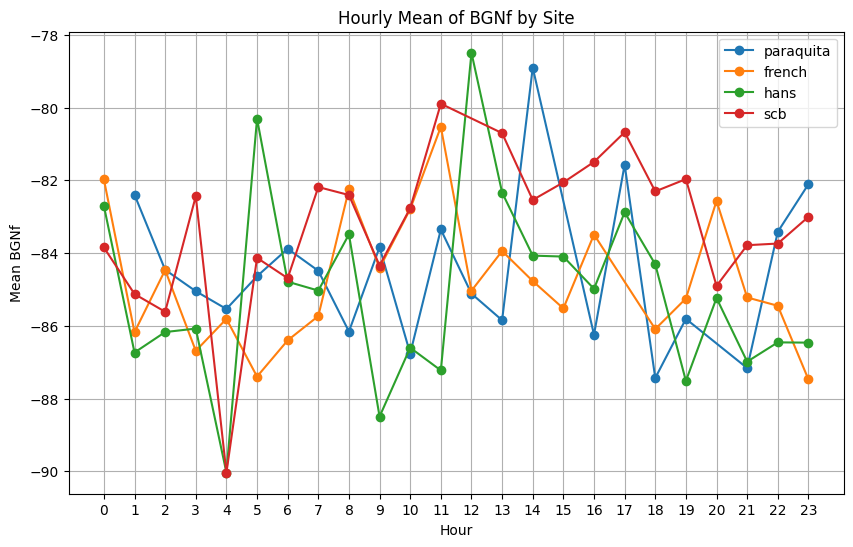

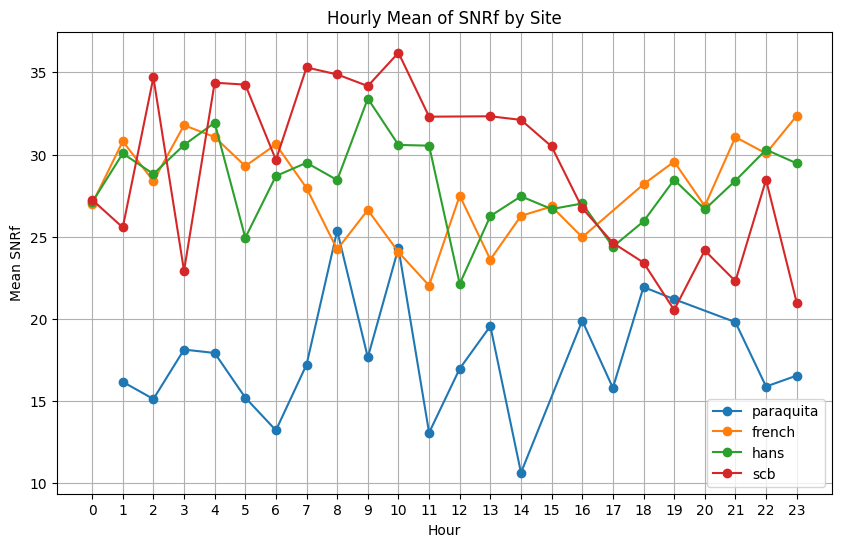

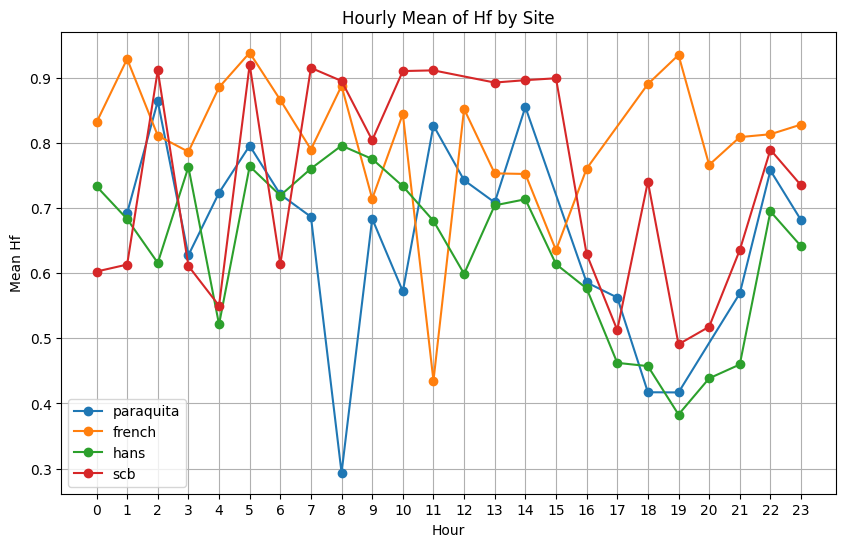

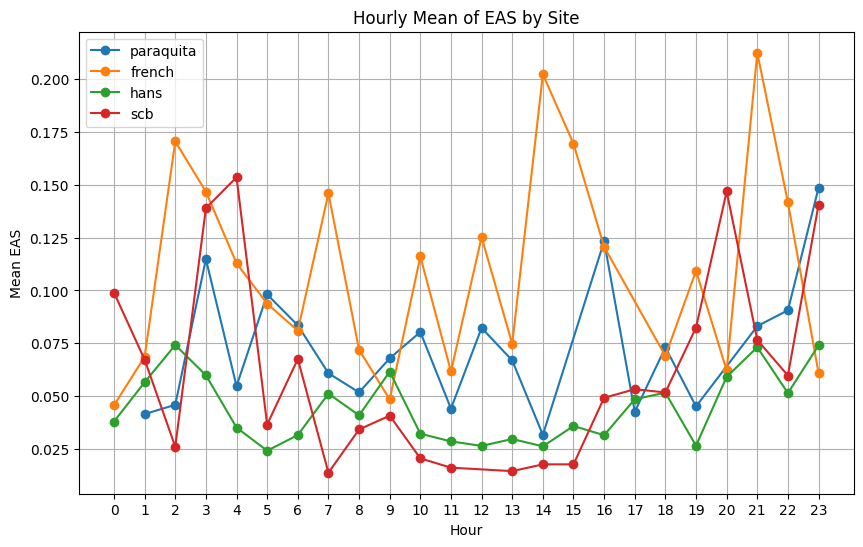

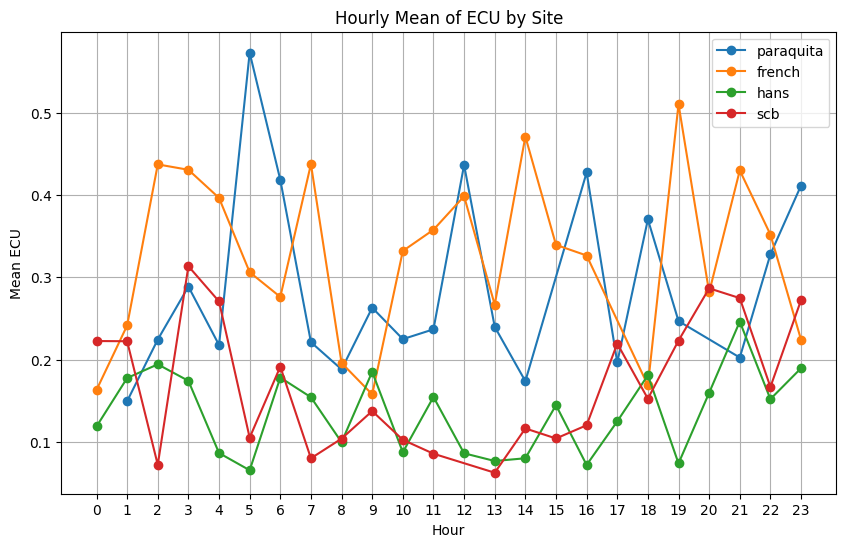

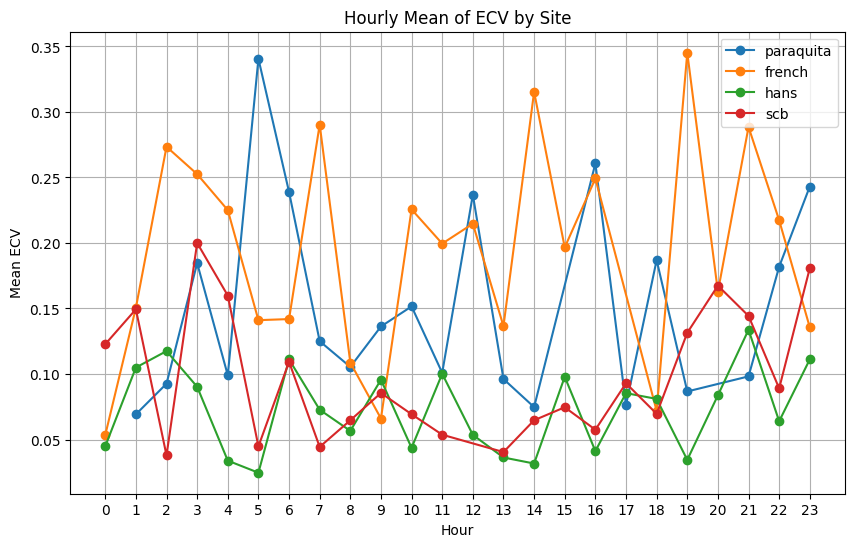

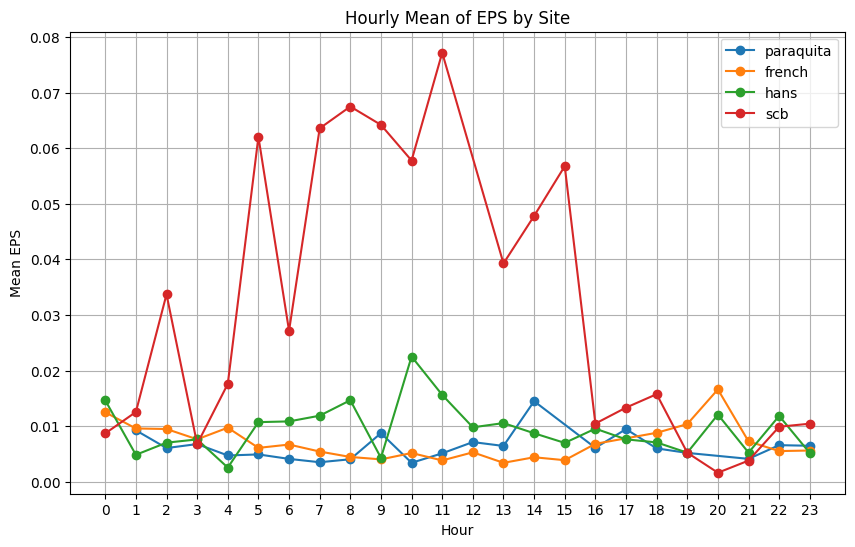

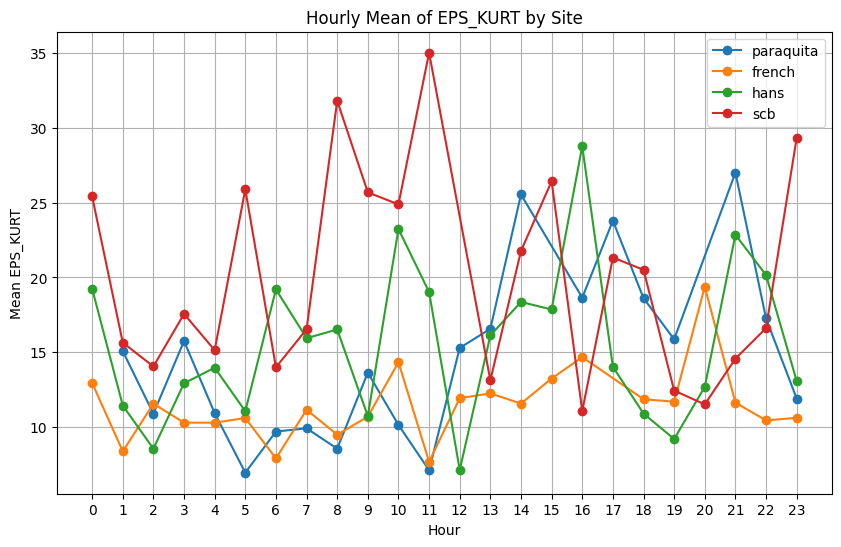

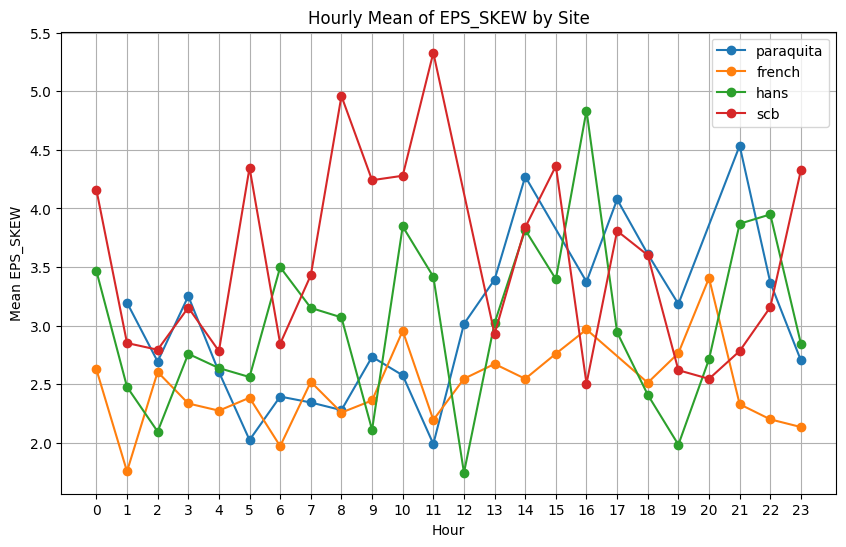

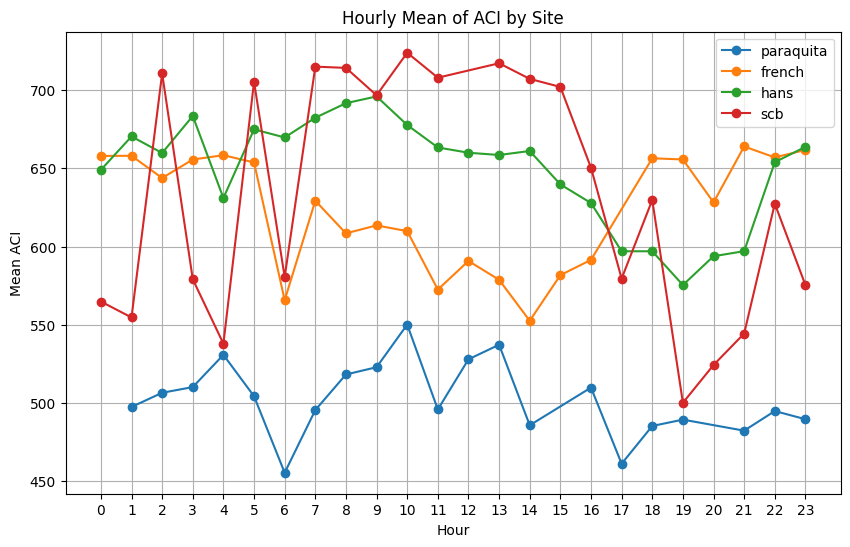

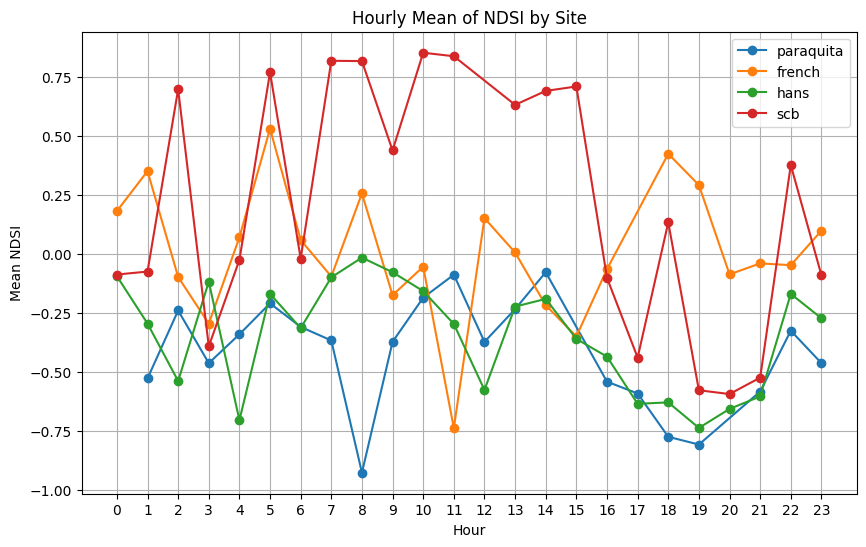

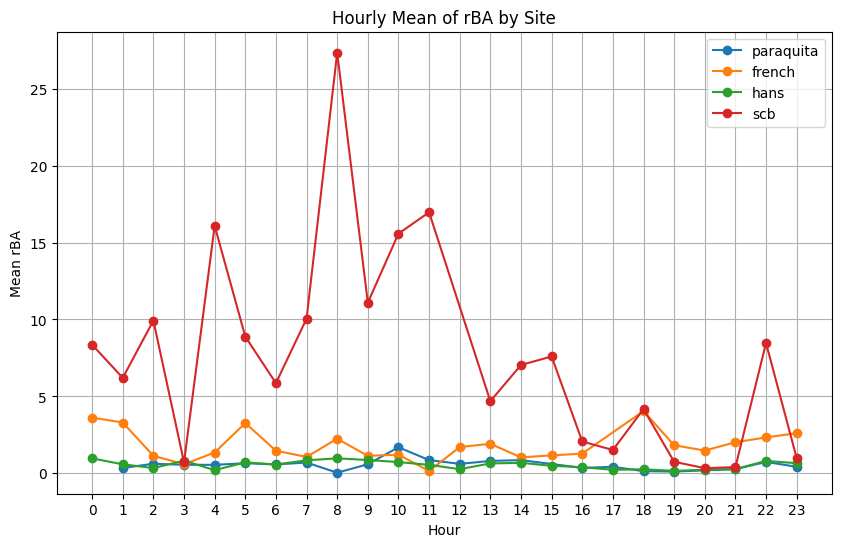

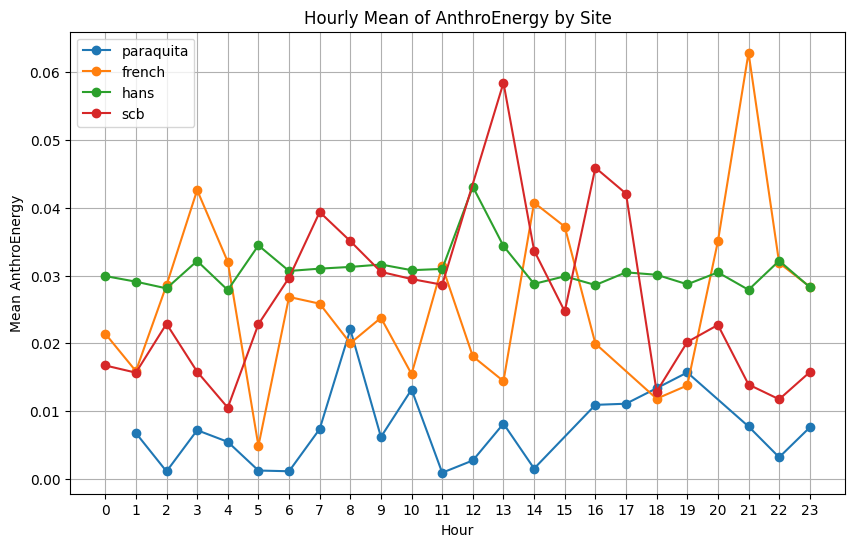

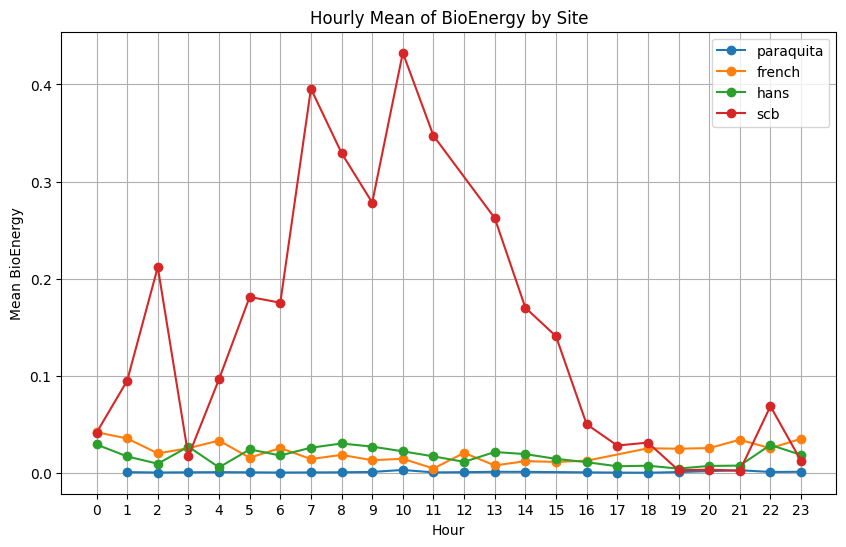

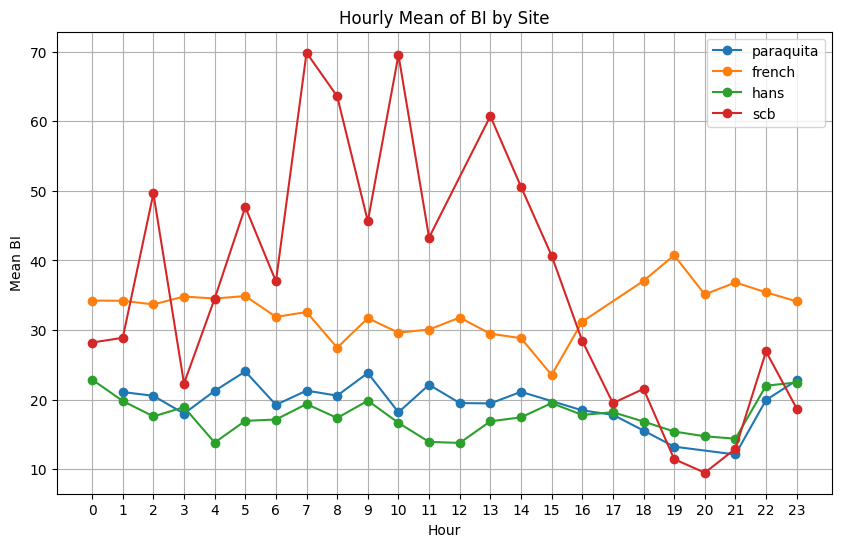

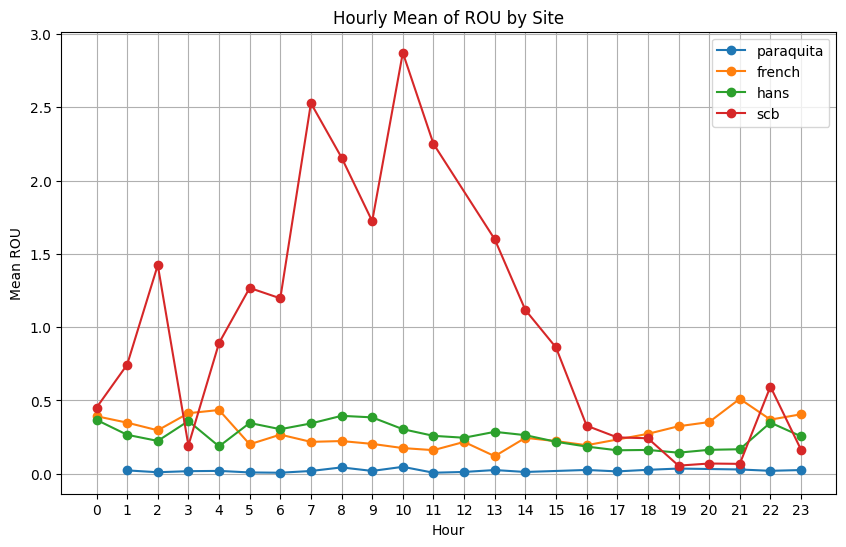

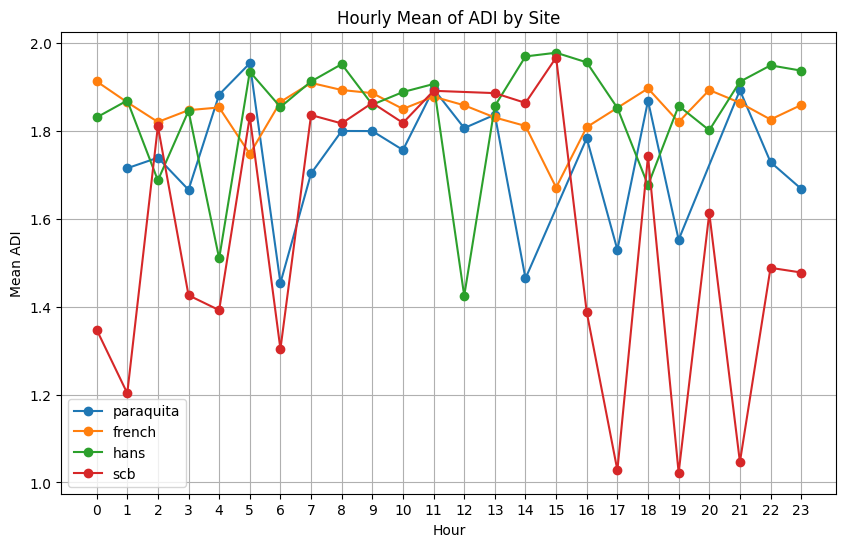

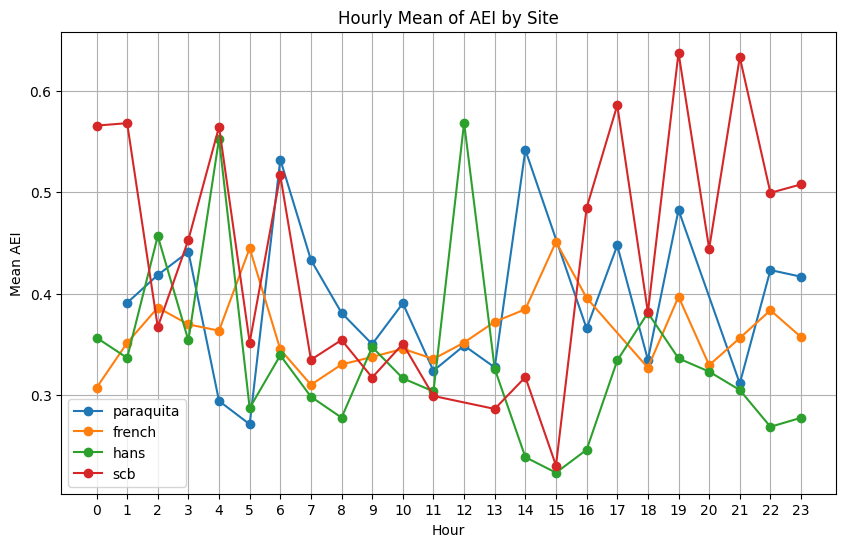

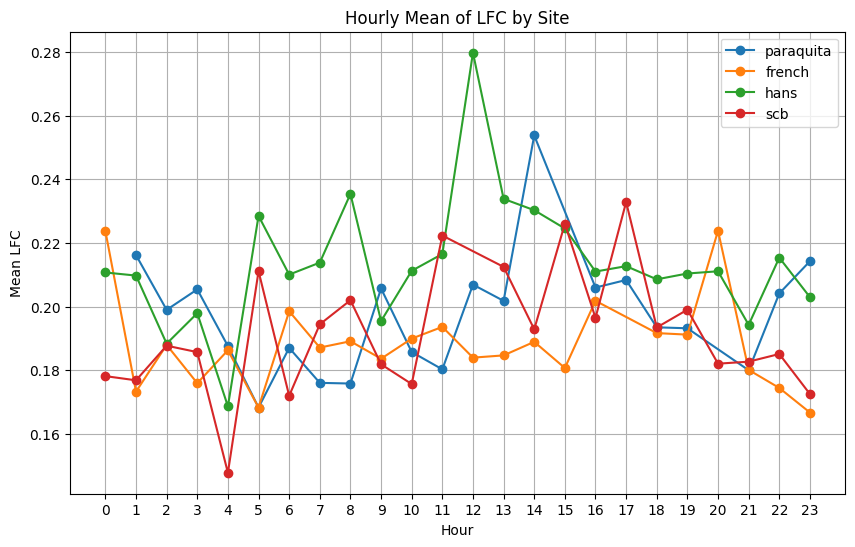

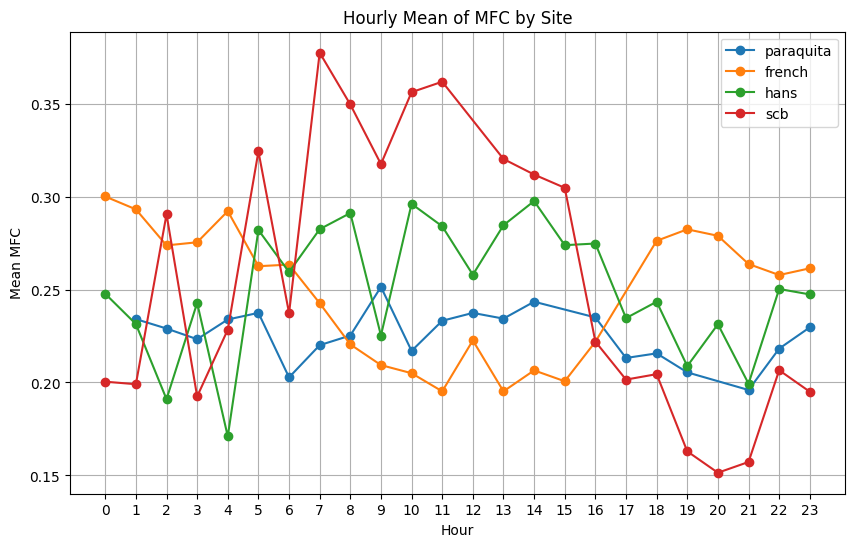

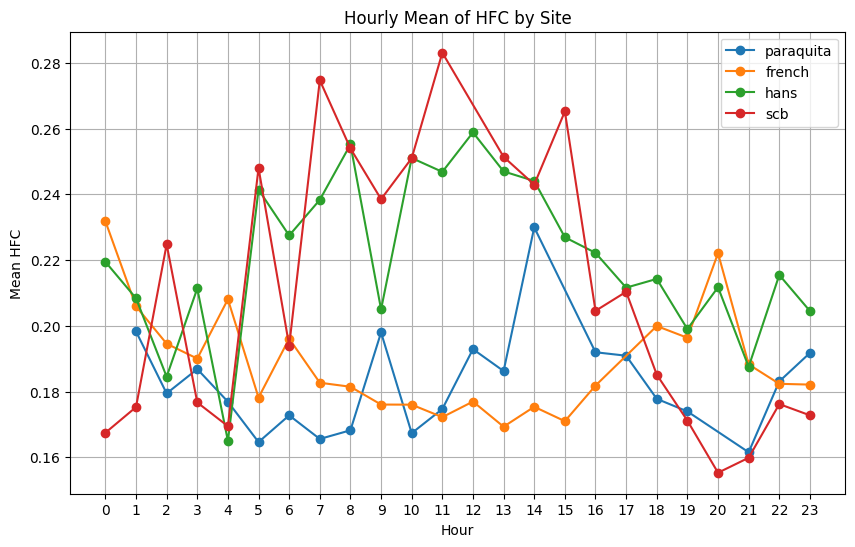

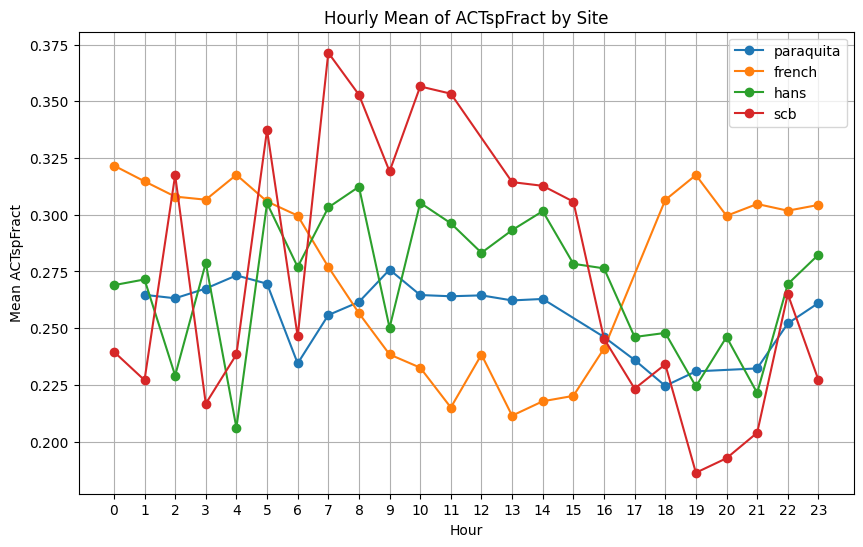

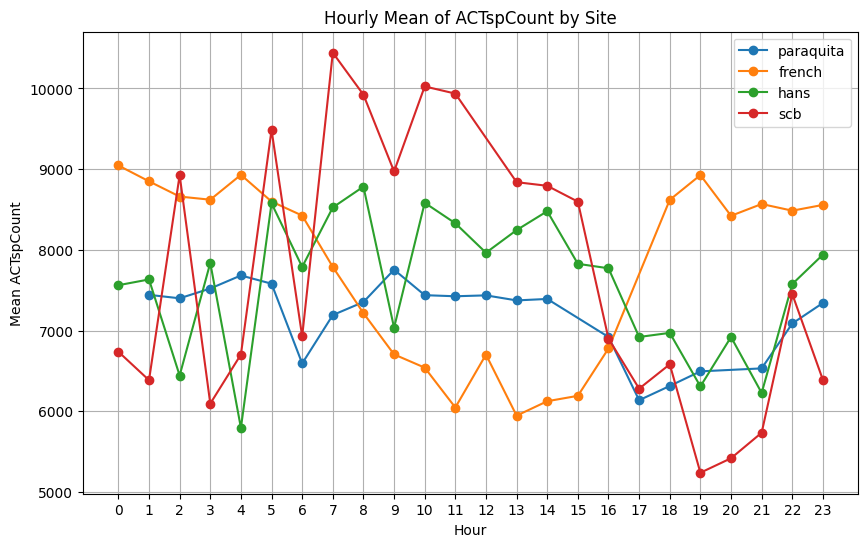

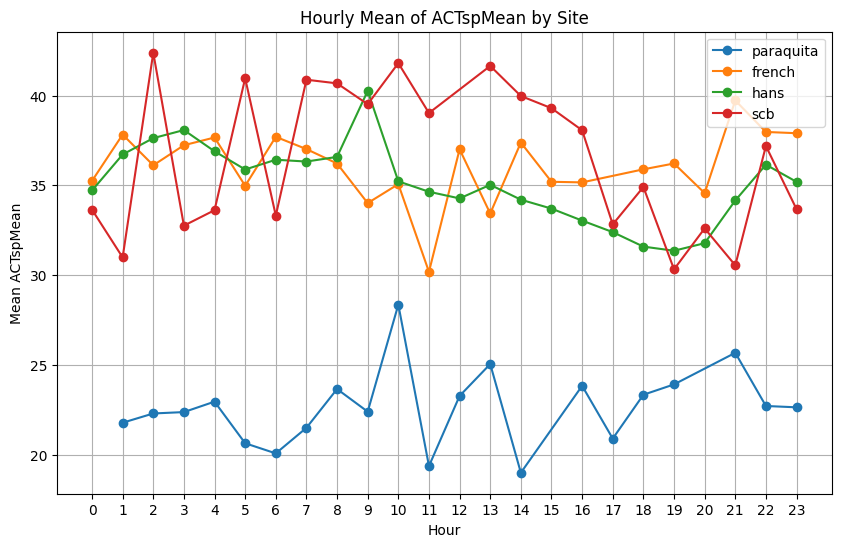

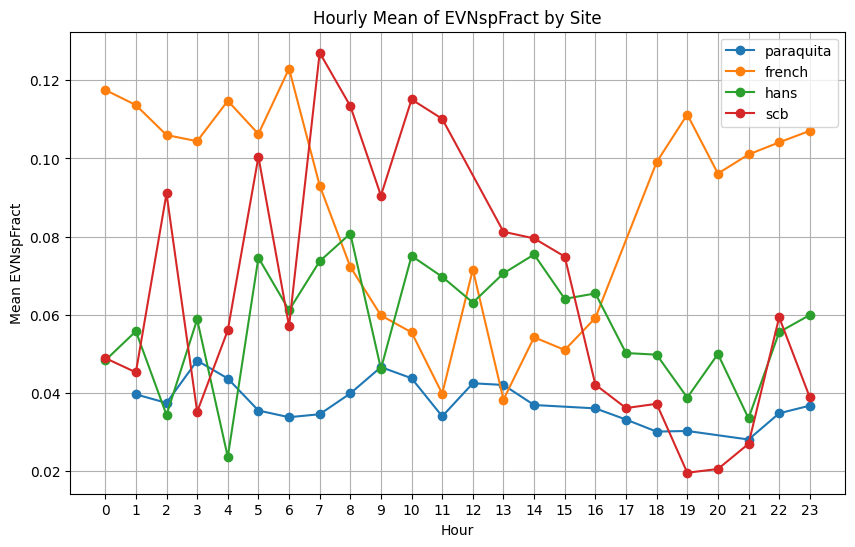

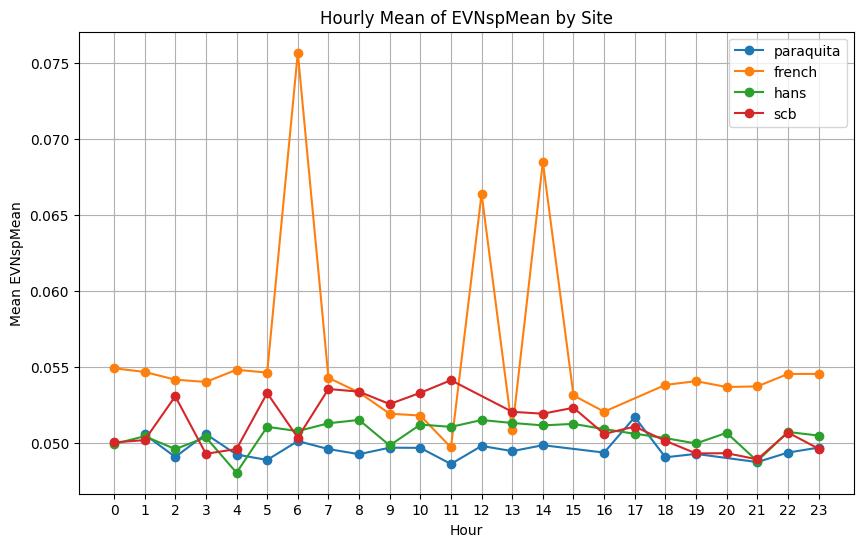

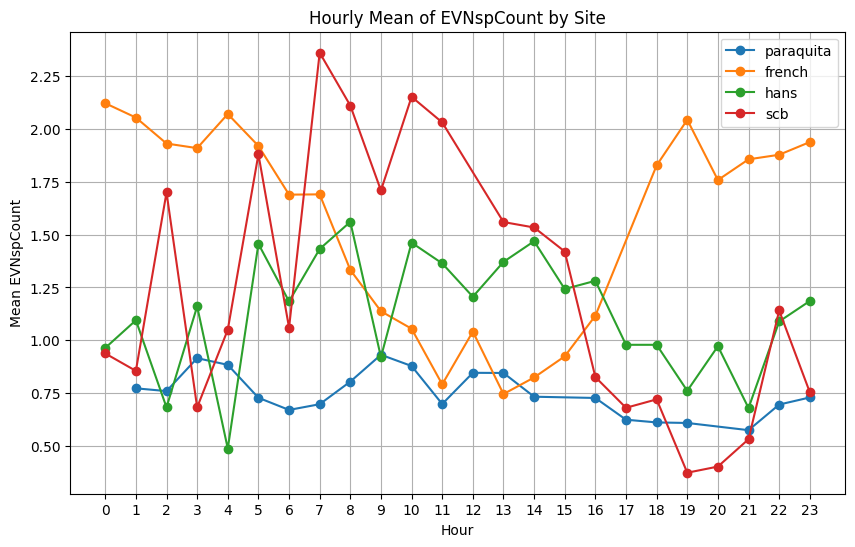

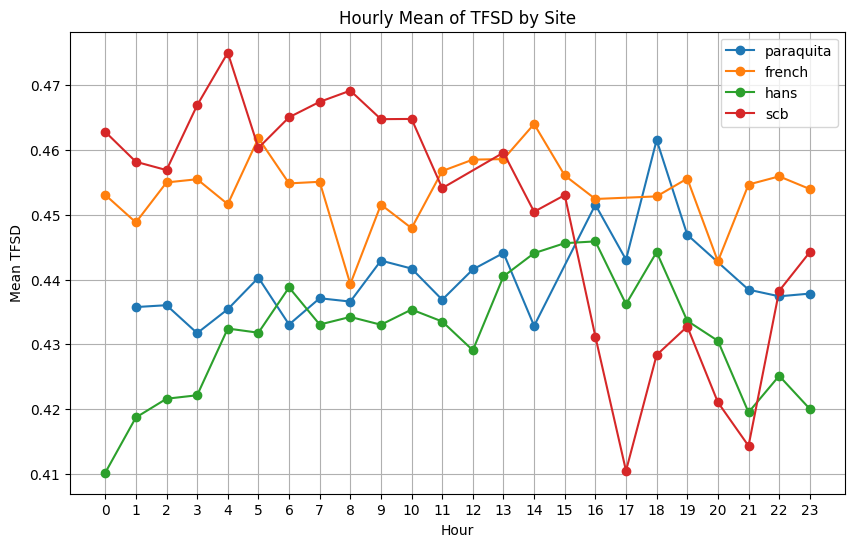

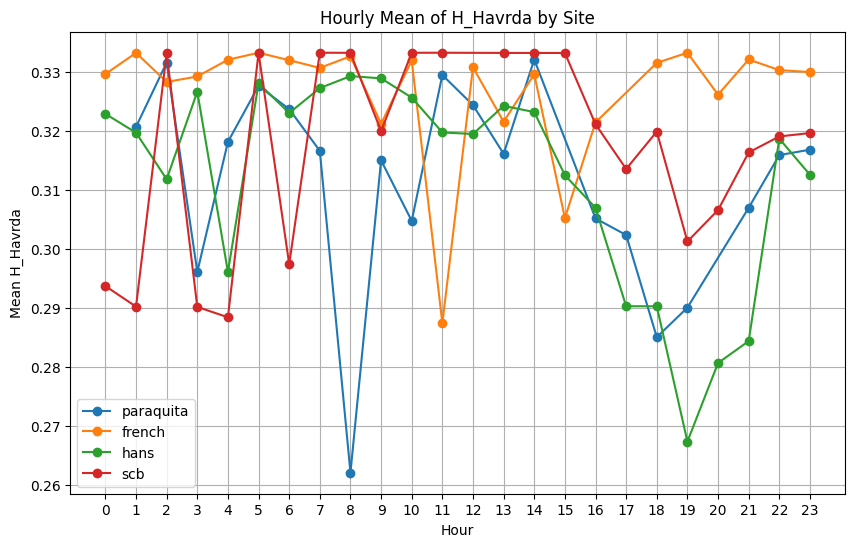

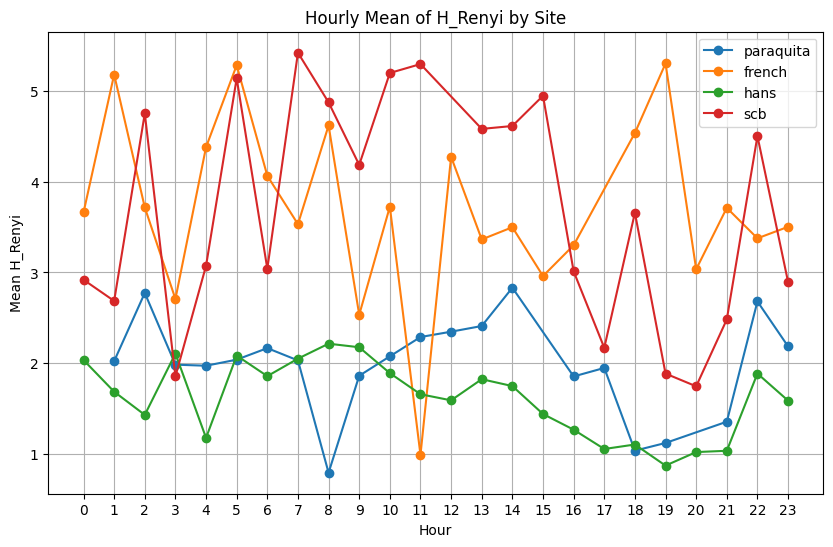

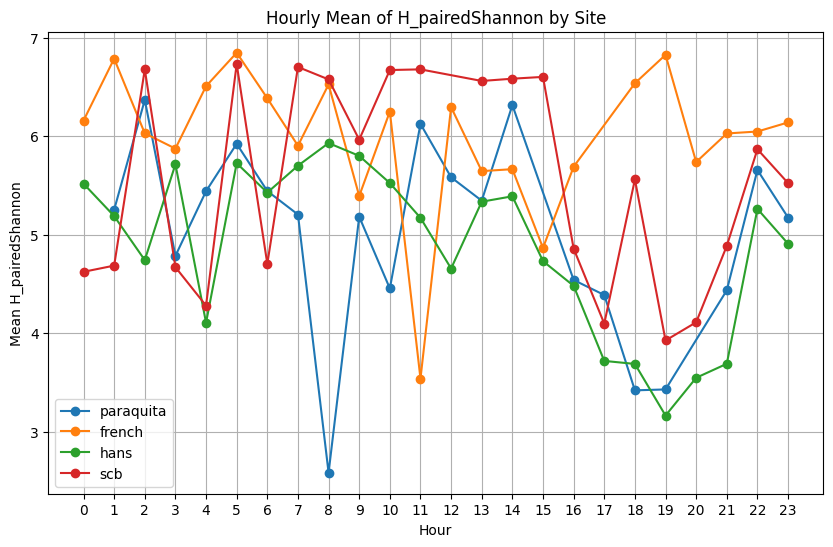

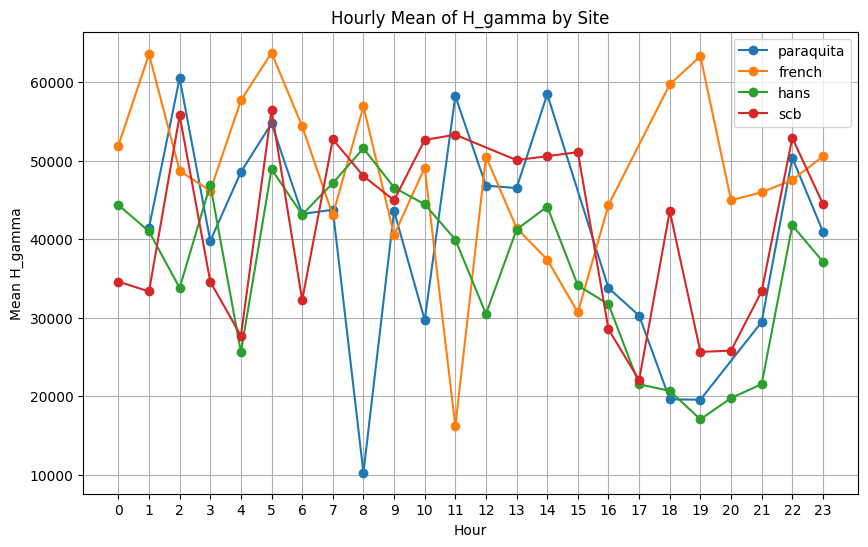

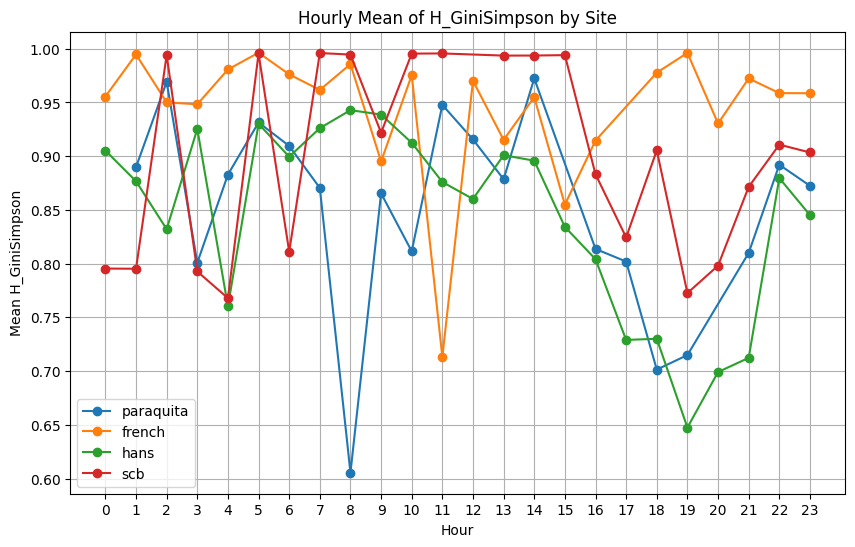

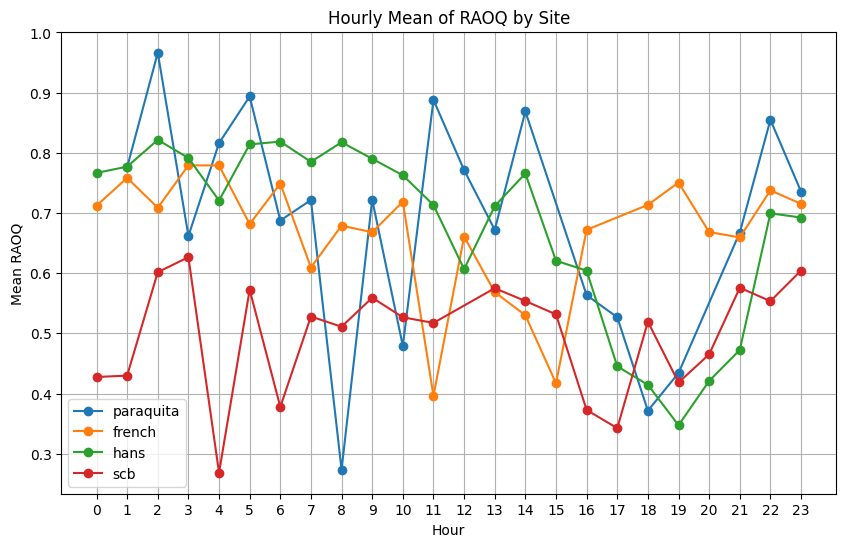

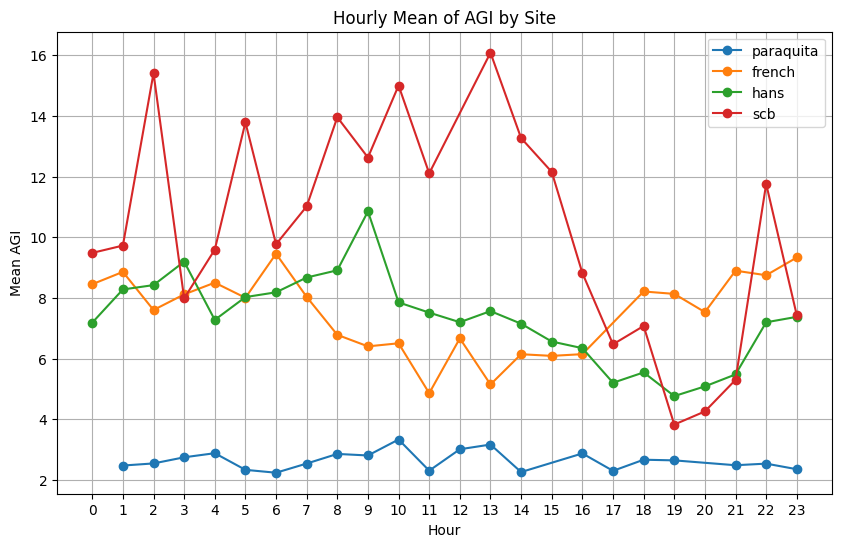

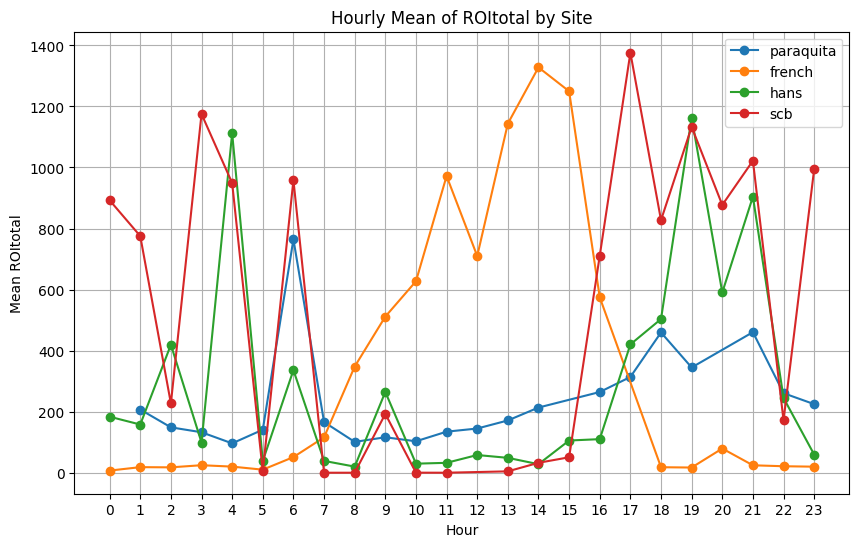

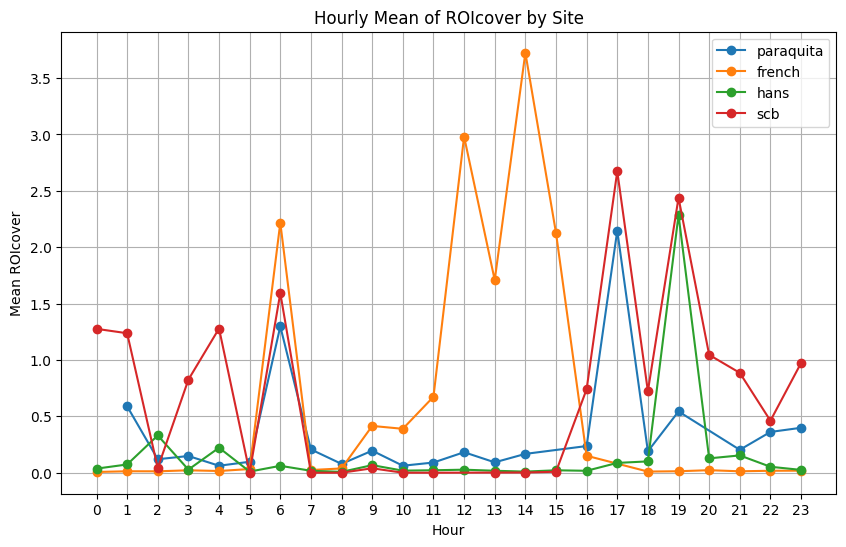

TypeError: agg function failed [how->mean,dtype->object]

<Figure size 1000x600 with 0 Axes>

In [23]:
# Loop through each index and create a plot comparing sites
for index_col in index_columns:
    plt.figure(figsize=(10, 6))  # Create a new figure for each index

    for site_name in site_mapping.values():  # Loop through sites
        site_data = df_indices[df_indices['Site'] == site_name]
        hourly_means = site_data.groupby('Hour')[index_col].mean() # Mean by hour
        plt.plot(hourly_means.index, hourly_means.values, label=site_name, marker='o') # Plot each site

    plt.title(f'Hourly Mean of {index_col} by Site')
    plt.xlabel('Hour')
    plt.ylabel(f'Mean {index_col}')
    plt.xticks(range(24))
    plt.grid(True)
    plt.legend()
    plt.show()

Violin Plots

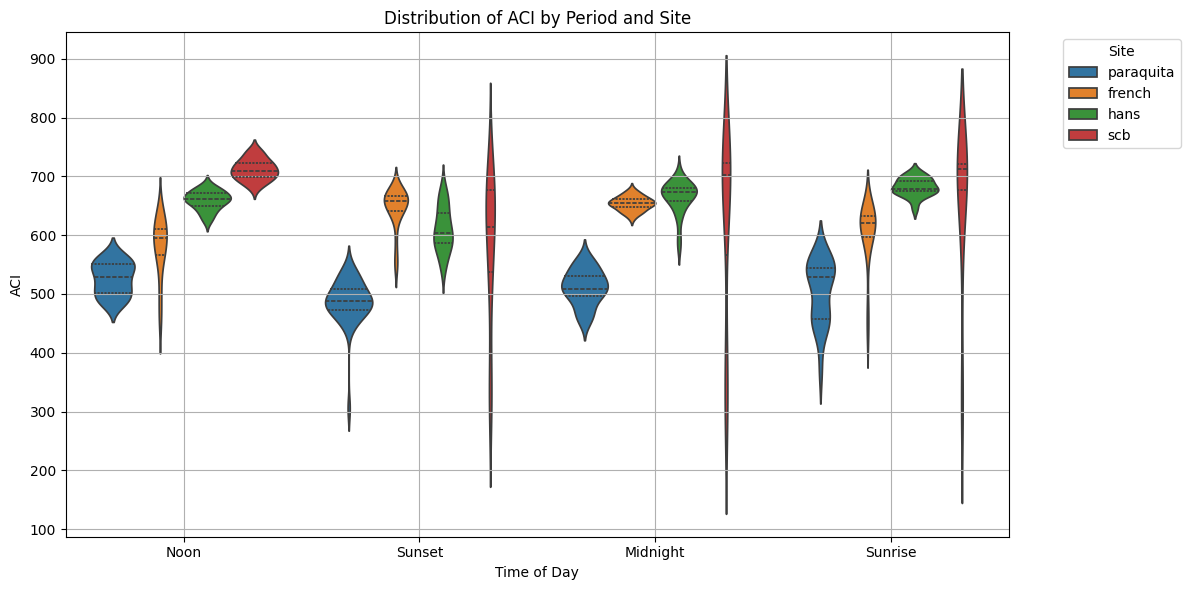

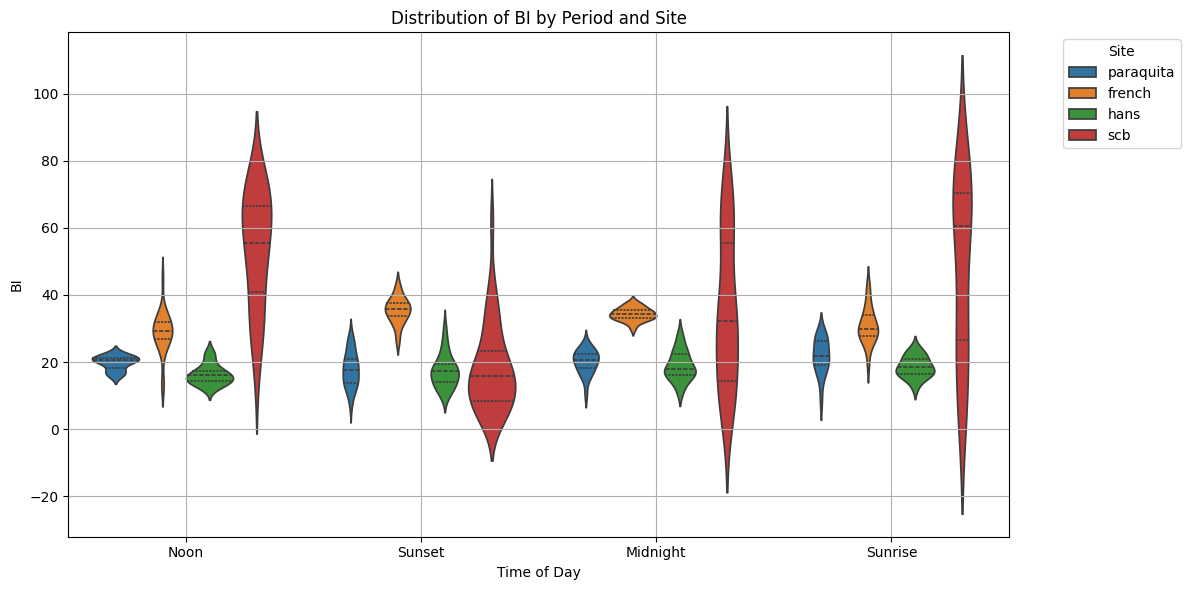

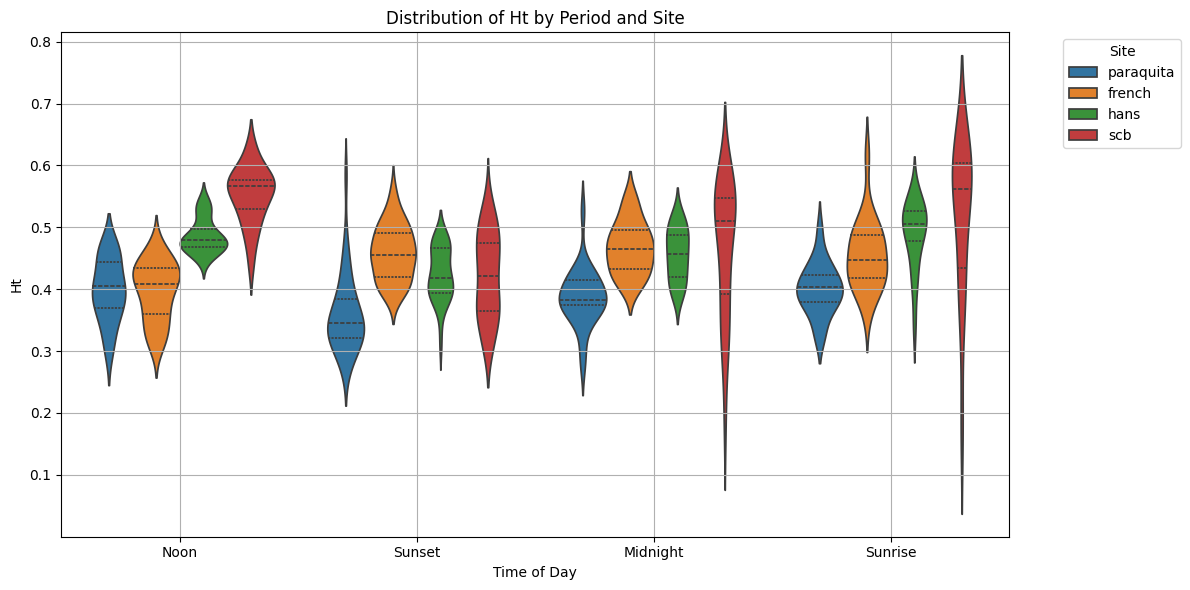

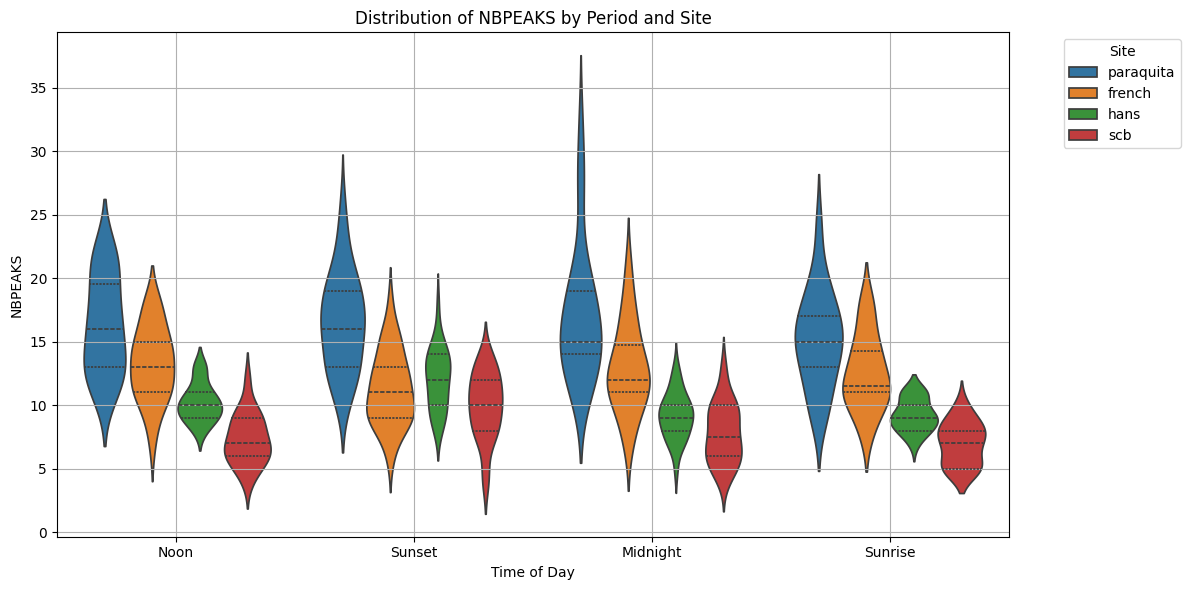

In [27]:
import seaborn as sns

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Define time periods based on hour
def map_period(hour):
    if 0 <= hour < 6:
        return 'Midnight'
    elif 6 <= hour < 10:
        return 'Sunrise'
    elif 10 <= hour < 16:
        return 'Noon'
    else:
        return 'Sunset'

# Add a 'Period' column to the DataFrame
df_indices['Period'] = df_indices['Hour'].apply(map_period)

# Limit to the desired index columns
selected_indices = ['ACI', 'BI', 'Ht', 'NBPEAKS']

# Plot violin plots for each selected index
for index_col in selected_indices:
    plt.figure(figsize=(12, 6))
    sns.violinplot(
        data=df_indices,
        x='Period',
        y=index_col,
        hue='Site',
        split=False,
        inner='quartile'
    )
    plt.title(f'Distribution of {index_col} by Period and Site')
    plt.xlabel('Time of Day')
    plt.ylabel(index_col)
    plt.grid(True)
    plt.legend(title='Site', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


In [113]:
# Group by site and hour and count the number of data points
hourly_counts = df_indices.groupby(['Site', 'Hour']).size().unstack(fill_value=0)

# Print the hourly counts
print("Data Point Counts by Site and Hour:")
print(hourly_counts)

Data Point Counts by Site and Hour:
Hour       0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  \
Site                                                                            
french      4   3   4   5   4   7   5   3   3   4   4   3   3   4   5   5   4   
hans        8   3   4   3   7   4   2   7   4   5   6   6   3   3   5   3   4   
paraquita   3   4   1   4   2   0   1   6   6   6   4   9   4   6   4   6   4   
scb         6   3   6   3   3   4   6   5   5   8   2   4   9   6   3   1   5   

Hour       17  18  19  20  21  22  23  
Site                                   
french      6   3   3   6   1   5   6  
hans        6   2   4   2   3   3   3  
paraquita   1   7   3   7   4   3   5  
scb         2   3   4   5   5   2   0  


In [114]:
for folder in folders:
    df = date_parser(folder, dateformat='%Y%m%d_%H%M%S', verbose=False)
    print(f"Folder: {folder}, DataFrame Length: {len(df)}")

Folder: /Volumes/SeaBABELa/BVI Mangroves_2024/BVI Mangroves_2024_Working/6863_Paraquita/6863_Paraquita_SoundFiles, DataFrame Length: 2152
Folder: /Volumes/SeaBABELa/BVI Mangroves_2024/BVI Mangroves_2024_Working/6879_French/6879_French_SoundFiles, DataFrame Length: 2358
Folder: /Volumes/SeaBABELa/BVI Mangroves_2024/BVI Mangroves_2024_Working/6880_HansA/6880_HansA_SoundFiles_Corrected, DataFrame Length: 1736
Folder: /Volumes/SeaBABELa/BVI Mangroves_2024/BVI Mangroves_2024_Working/6884_SeaCowBay/6884_SeaCowBay_SoundFiles, DataFrame Length: 2452


In [24]:
# Define the file path
output_path = "/Users/jillmunger/Desktop/UNH/research/acoustic_indices/df_indices_forapeek.csv"

# Export the DataFrame to a CSV file for inspection
df_indices.to_csv(output_path, index=False)  # index=False prevents writing the index column
